In [1]:
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error

In [4]:
import pickle

In [5]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("rajat_greentaxi_experiment")


<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02_exptracking/mlruns/1', creation_time=1745670370058, experiment_id='1', last_update_time=1745670370058, lifecycle_stage='active', name='rajat_greentaxi_experiment', tags={}>

In [6]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

    df.duration = df.duration.apply(lambda td: td.total_seconds()/60)

    df = df[((df.duration >= 1) & (df.duration <= 60))]

    categorical = ['PULocationID','DOLocationID']

    df[categorical] = df[categorical].astype(str)
    
    return df

In [7]:
df_train = read_dataframe('data/green_tripdata_2024-01.parquet')
df_val = read_dataframe('data/green_tripdata_2024-02.parquet')

In [8]:
len(df_train), len(df_val)

(54373, 51497)

In [9]:
df_train['pu_do'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['pu_do'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [10]:
categorical = ['pu_do']#['PULocationID','DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient = 'records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient = 'records')
X_val = dv.transform(val_dicts)

target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Mean Sq. error is: 5.982617137342204 minutes


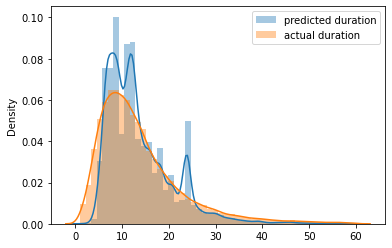

In [11]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

sns.distplot(y_pred,label='predicted duration')
sns.distplot(y_train,label='actual duration')

plt.legend()

Mean_sqError = mean_squared_error(y_val, y_pred, squared=False)
print(f"Mean Sq. error is: {Mean_sqError} minutes")

In [12]:
with open('model/model_linreg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [14]:
with mlflow.start_run():

    mlflow.set_tag("developer", "Rajat")
    
    mlflow.log_param("train-data-path", "data/green_tripdata_2024-01.parquet")
    mlflow.log_param("val-data-path", "data/green_tripdata_2024-02.parquet")
    
    alpha = 0.1
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    # First method os saving a model
    mlflow.log_artifact(local_path="model/model_linreg.bin", artifact_path="models_pickle")

In [15]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [16]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [17]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid,"validation")],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
        
    return {'loss' : rmse, 'status' : STATUS_OK}

In [34]:
search_space = {
    'max_depth' : scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate' : hp.loguniform('learning_rate', -3, 0), # bw exp(-3) and exp(0)
    'reg_alpha' : hp.loguniform('reg_aplha', -5, -1),
    'reg_lambda' : hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight' : hp.loguniform('min_child_weight', -1, 3),
    'objective' : 'reg:linear', 
    'seed' : 42,
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials())

  0%|                                                       | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:10:09] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.71553                                                                        
[1]	validation-rmse:5.80801                                                                        
[2]	validation-rmse:5.48562                                                                        
[3]	validation-rmse:5.36065                                                                        
[4]	validation-rmse:5.31171                                                                        
[5]	validation-rmse:5.28163                                                                        
[6]	validation-rmse:5.26861                                                                        
[7]	validation-rmse:5.26083                                                                        
[8]	validation-rmse:5.25865                                                                        
[9]	validation-rmse:5.25163                                                                        


[162]	validation-rmse:5.15150                                                                      
[163]	validation-rmse:5.15140                                                                      
[164]	validation-rmse:5.14976                                                                      
[165]	validation-rmse:5.14879                                                                      
[166]	validation-rmse:5.15051                                                                      
[167]	validation-rmse:5.15092                                                                      
[168]	validation-rmse:5.15151                                                                      
[169]	validation-rmse:5.15144                                                                      
[170]	validation-rmse:5.15180                                                                      
[171]	validation-rmse:5.15245                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:10:19] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.10247                                                                        
[1]	validation-rmse:6.09905                                                                        
[2]	validation-rmse:5.63243                                                                        
[3]	validation-rmse:5.42061                                                                        
[4]	validation-rmse:5.32348                                                                        
[5]	validation-rmse:5.27782                                                                        
[6]	validation-rmse:5.25384                                                                        
[7]	validation-rmse:5.23909                                                                        
[8]	validation-rmse:5.22884                                                                        
[9]	validation-rmse:5.22516                                                                        


[162]	validation-rmse:5.15973                                                                      
[163]	validation-rmse:5.16026                                                                      
[164]	validation-rmse:5.15981                                                                      
[165]	validation-rmse:5.16005                                                                      
[166]	validation-rmse:5.16065                                                                      
[167]	validation-rmse:5.16124                                                                      
[168]	validation-rmse:5.16144                                                                      
[169]	validation-rmse:5.16139                                                                      
[170]	validation-rmse:5.16215                                                                      
[171]	validation-rmse:5.16198                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:10:37] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.74943                                                                        
[1]	validation-rmse:5.85598                                                                        
[2]	validation-rmse:5.55225                                                                        
[3]	validation-rmse:5.44225                                                                        
[4]	validation-rmse:5.40322                                                                        
[5]	validation-rmse:5.38016                                                                        
[6]	validation-rmse:5.36569                                                                        
[7]	validation-rmse:5.36040                                                                        
[8]	validation-rmse:5.34723                                                                        
[9]	validation-rmse:5.33892                                                                        


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:11:08] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.17773                                                                        
[1]	validation-rmse:6.16266                                                                        
[2]	validation-rmse:5.66407                                                                        
[3]	validation-rmse:5.42891                                                                        
[4]	validation-rmse:5.32138                                                                        
[5]	validation-rmse:5.27055                                                                        
[6]	validation-rmse:5.24265                                                                        
[7]	validation-rmse:5.22257                                                                        
[8]	validation-rmse:5.21480                                                                        
[9]	validation-rmse:5.20761                                                                        


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:11:30] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.51720                                                                        
[1]	validation-rmse:8.00657                                                                        
[2]	validation-rmse:7.57043                                                                        
[3]	validation-rmse:7.19968                                                                        
[4]	validation-rmse:6.88651                                                                        
[5]	validation-rmse:6.62302                                                                        
[6]	validation-rmse:6.40229                                                                        
[7]	validation-rmse:6.21864                                                                        
[8]	validation-rmse:6.06582                                                                        
[9]	validation-rmse:5.93969                                                                        


[162]	validation-rmse:5.26912                                                                      
[163]	validation-rmse:5.26885                                                                      
[164]	validation-rmse:5.26901                                                                      
[165]	validation-rmse:5.26900                                                                      
[166]	validation-rmse:5.26862                                                                      
[167]	validation-rmse:5.26833                                                                      
[168]	validation-rmse:5.26841                                                                      
[169]	validation-rmse:5.26826                                                                      
[170]	validation-rmse:5.26703                                                                      
[171]	validation-rmse:5.26698                                                                      


[324]	validation-rmse:5.26009                                                                      
[325]	validation-rmse:5.26012                                                                      
[326]	validation-rmse:5.26007                                                                      
[327]	validation-rmse:5.25992                                                                      
[328]	validation-rmse:5.26019                                                                      
[329]	validation-rmse:5.26032                                                                      
[330]	validation-rmse:5.26028                                                                      
[331]	validation-rmse:5.26029                                                                      
[332]	validation-rmse:5.26006                                                                      
[333]	validation-rmse:5.26019                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:13:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.40253                                                                        
[1]	validation-rmse:7.81249                                                                        
[2]	validation-rmse:7.33189                                                                        
[3]	validation-rmse:6.93526                                                                        
[4]	validation-rmse:6.62103                                                                        
[5]	validation-rmse:6.36857                                                                        
[6]	validation-rmse:6.15521                                                                        
[7]	validation-rmse:5.99363                                                                        
[8]	validation-rmse:5.85773                                                                        
[9]	validation-rmse:5.74950                                                                        


[162]	validation-rmse:5.25246                                                                      
[163]	validation-rmse:5.25259                                                                      
[164]	validation-rmse:5.25222                                                                      
[165]	validation-rmse:5.25185                                                                      
[166]	validation-rmse:5.25165                                                                      
[167]	validation-rmse:5.25190                                                                      
[168]	validation-rmse:5.25172                                                                      
[169]	validation-rmse:5.25123                                                                      
[170]	validation-rmse:5.25121                                                                      
[171]	validation-rmse:5.25131                                                                      


[324]	validation-rmse:5.23776                                                                      
[325]	validation-rmse:5.23731                                                                      
[326]	validation-rmse:5.23740                                                                      
[327]	validation-rmse:5.23744                                                                      
[328]	validation-rmse:5.23764                                                                      
[329]	validation-rmse:5.23743                                                                      
[330]	validation-rmse:5.23738                                                                      
[331]	validation-rmse:5.23630                                                                      
[332]	validation-rmse:5.23628                                                                      
[333]	validation-rmse:5.23672                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:14:11] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.19616                                                                        
[1]	validation-rmse:6.19007                                                                        
[2]	validation-rmse:5.68961                                                                        
[3]	validation-rmse:5.44927                                                                        
[4]	validation-rmse:5.33843                                                                        
[5]	validation-rmse:5.27392                                                                        
[6]	validation-rmse:5.24018                                                                        
[7]	validation-rmse:5.21834                                                                        
[8]	validation-rmse:5.20360                                                                        
[9]	validation-rmse:5.19503                                                                        


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:14:27] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.91133                                                                        
[1]	validation-rmse:5.47504                                                                        
[2]	validation-rmse:5.39950                                                                        
[3]	validation-rmse:5.38965                                                                        
[4]	validation-rmse:5.38559                                                                        
[5]	validation-rmse:5.37781                                                                        
[6]	validation-rmse:5.37453                                                                        
[7]	validation-rmse:5.37022                                                                        
[8]	validation-rmse:5.36616                                                                        
[9]	validation-rmse:5.36443                                                                        


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:14:33] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:5.55318                                                                        
[3]	validation-rmse:5.45498                                                                        
[4]	validation-rmse:5.41803                                                                        
[5]	validation-rmse:5.40005                                                                        
[6]	validation-rmse:5.39065                                                                        
[7]	validation-rmse:5.38432                                                                        
[8]	validation-rmse:5.37471                                                                        
[9]	validation-rmse:5.37112                                                                        
[10]	validation-rmse:5.36721                                                                       
[11]	validation-rmse:5.36431                                                                       


[164]	validation-rmse:5.22281                                                                      
[165]	validation-rmse:5.22292                                                                      
[166]	validation-rmse:5.22221                                                                      
[167]	validation-rmse:5.22206                                                                      
[168]	validation-rmse:5.22206                                                                      
[169]	validation-rmse:5.22200                                                                      
[170]	validation-rmse:5.22161                                                                      
[171]	validation-rmse:5.22166                                                                      
[172]	validation-rmse:5.22136                                                                      
[173]	validation-rmse:5.22168                                                                      


[326]	validation-rmse:5.20655                                                                      
[327]	validation-rmse:5.20677                                                                      
[328]	validation-rmse:5.20699                                                                      
[329]	validation-rmse:5.20666                                                                      
[330]	validation-rmse:5.20664                                                                      
[331]	validation-rmse:5.20659                                                                      
[332]	validation-rmse:5.20633                                                                      
[333]	validation-rmse:5.20582                                                                      
[334]	validation-rmse:5.20610                                                                      
[335]	validation-rmse:5.20612                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:14:47] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.50515                                                                        
[1]	validation-rmse:7.98336                                                                        
[2]	validation-rmse:7.53394                                                                        
[3]	validation-rmse:7.15235                                                                        
[4]	validation-rmse:6.82859                                                                        
[5]	validation-rmse:6.55325                                                                        
[6]	validation-rmse:6.32287                                                                        
[7]	validation-rmse:6.13045                                                                        
[8]	validation-rmse:5.96957                                                                        
[9]	validation-rmse:5.83672                                                                        


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:16:02] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.68508                                                                        
[1]	validation-rmse:6.75654                                                                        
[2]	validation-rmse:6.17474                                                                        
[3]	validation-rmse:5.81904                                                                        
[4]	validation-rmse:5.60029                                                                        
[5]	validation-rmse:5.47342                                                                        
[6]	validation-rmse:5.39138                                                                        
[7]	validation-rmse:5.34162                                                                        
[8]	validation-rmse:5.30646                                                                        
[9]	validation-rmse:5.27752                                                                        


[162]	validation-rmse:5.14885                                                                      
[163]	validation-rmse:5.14842                                                                      
[164]	validation-rmse:5.14866                                                                      
[165]	validation-rmse:5.14893                                                                      
[166]	validation-rmse:5.14959                                                                      
[167]	validation-rmse:5.14961                                                                      
[168]	validation-rmse:5.14980                                                                      
[169]	validation-rmse:5.15045                                                                      
[170]	validation-rmse:5.14946                                                                      
[171]	validation-rmse:5.14966                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:16:20] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:5.47229                                                                        
[7]	validation-rmse:5.46634                                                                        
[8]	validation-rmse:5.45876                                                                        
[9]	validation-rmse:5.45653                                                                        
[10]	validation-rmse:5.44489                                                                       
[11]	validation-rmse:5.44226                                                                       
[12]	validation-rmse:5.43534                                                                       
[13]	validation-rmse:5.43140                                                                       
[14]	validation-rmse:5.42995                                                                       
[15]	validation-rmse:5.42443                                                                       


[168]	validation-rmse:5.23362                                                                      
[169]	validation-rmse:5.23131                                                                      
[170]	validation-rmse:5.23160                                                                      
[171]	validation-rmse:5.23130                                                                      
[172]	validation-rmse:5.23066                                                                      
[173]	validation-rmse:5.23112                                                                      
[174]	validation-rmse:5.23100                                                                      
[175]	validation-rmse:5.23146                                                                      
[176]	validation-rmse:5.23079                                                                      
[177]	validation-rmse:5.22765                                                                      


[330]	validation-rmse:5.16580                                                                      
[331]	validation-rmse:5.16598                                                                      
[332]	validation-rmse:5.16619                                                                      
[333]	validation-rmse:5.16609                                                                      
[334]	validation-rmse:5.16575                                                                      
[335]	validation-rmse:5.16605                                                                      
[336]	validation-rmse:5.16567                                                                      
[337]	validation-rmse:5.16553                                                                      
[338]	validation-rmse:5.16555                                                                      
[339]	validation-rmse:5.16576                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:16:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.78904                                                                        
[1]	validation-rmse:8.49041                                                                        
[2]	validation-rmse:8.21537                                                                        
[3]	validation-rmse:7.96267                                                                        
[4]	validation-rmse:7.73117                                                                        
[5]	validation-rmse:7.51569                                                                        
[6]	validation-rmse:7.31978                                                                        
[7]	validation-rmse:7.13622                                                                        
[8]	validation-rmse:6.97360                                                                        
[9]	validation-rmse:6.82034                                                                        


[162]	validation-rmse:5.24939                                                                      
[163]	validation-rmse:5.24936                                                                      
[164]	validation-rmse:5.24898                                                                      
[165]	validation-rmse:5.24833                                                                      
[166]	validation-rmse:5.24834                                                                      
[167]	validation-rmse:5.24781                                                                      
[168]	validation-rmse:5.24758                                                                      
[169]	validation-rmse:5.24747                                                                      
[170]	validation-rmse:5.24736                                                                      
[171]	validation-rmse:5.24734                                                                      


[324]	validation-rmse:5.22898                                                                      
[325]	validation-rmse:5.22890                                                                      
[326]	validation-rmse:5.22886                                                                      
[327]	validation-rmse:5.22906                                                                      
[328]	validation-rmse:5.22901                                                                      
[329]	validation-rmse:5.22885                                                                      
[330]	validation-rmse:5.22882                                                                      
[331]	validation-rmse:5.22873                                                                      
[332]	validation-rmse:5.22862                                                                      
[333]	validation-rmse:5.22865                                                                      


[486]	validation-rmse:5.22075                                                                      
[487]	validation-rmse:5.22060                                                                      
[488]	validation-rmse:5.22077                                                                      
[489]	validation-rmse:5.22079                                                                      
[490]	validation-rmse:5.22063                                                                      
[491]	validation-rmse:5.22060                                                                      
[492]	validation-rmse:5.22052                                                                      
[493]	validation-rmse:5.22052                                                                      
[494]	validation-rmse:5.22054                                                                      
[495]	validation-rmse:5.22054                                                                      


[648]	validation-rmse:5.21767                                                                      
[649]	validation-rmse:5.21765                                                                      
[650]	validation-rmse:5.21772                                                                      
[651]	validation-rmse:5.21773                                                                      
[652]	validation-rmse:5.21767                                                                      
[653]	validation-rmse:5.21763                                                                      
[654]	validation-rmse:5.21762                                                                      
[655]	validation-rmse:5.21765                                                                      
[656]	validation-rmse:5.21764                                                                      
[657]	validation-rmse:5.21758                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:18:14] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.74931                                                                        
[1]	validation-rmse:6.83599                                                                        
[2]	validation-rmse:6.24212                                                                        
[3]	validation-rmse:5.86728                                                                        
[4]	validation-rmse:5.63589                                                                        
[5]	validation-rmse:5.49422                                                                        
[6]	validation-rmse:5.40974                                                                        
[7]	validation-rmse:5.35896                                                                        
[8]	validation-rmse:5.32654                                                                        
[9]	validation-rmse:5.30433                                                                        


[162]	validation-rmse:5.20130                                                                      
[163]	validation-rmse:5.20095                                                                      
[164]	validation-rmse:5.20139                                                                      
[165]	validation-rmse:5.20143                                                                      
[166]	validation-rmse:5.20161                                                                      
 28%|████████                     | 14/50 [08:43<27:51, 46.42s/trial, best loss: 5.148311107558906]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:18:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.03548                                                                        
[1]	validation-rmse:7.24504                                                                        
[2]	validation-rmse:6.67562                                                                        
[3]	validation-rmse:6.27254                                                                        
[4]	validation-rmse:5.99286                                                                        
[5]	validation-rmse:5.80118                                                                        
[6]	validation-rmse:5.67002                                                                        
[7]	validation-rmse:5.57923                                                                        
[8]	validation-rmse:5.51475                                                                        
[9]	validation-rmse:5.47215                                                                        


[162]	validation-rmse:5.26724                                                                      
[163]	validation-rmse:5.26728                                                                      
[164]	validation-rmse:5.26691                                                                      
[165]	validation-rmse:5.26664                                                                      
[166]	validation-rmse:5.26663                                                                      
[167]	validation-rmse:5.26647                                                                      
[168]	validation-rmse:5.26645                                                                      
[169]	validation-rmse:5.26664                                                                      
[170]	validation-rmse:5.26672                                                                      
[171]	validation-rmse:5.26587                                                                      


[324]	validation-rmse:5.24889                                                                      
[325]	validation-rmse:5.24899                                                                      
[326]	validation-rmse:5.24893                                                                      
[327]	validation-rmse:5.24853                                                                      
[328]	validation-rmse:5.24870                                                                      
[329]	validation-rmse:5.24869                                                                      
[330]	validation-rmse:5.24881                                                                      
[331]	validation-rmse:5.24862                                                                      
[332]	validation-rmse:5.24880                                                                      
[333]	validation-rmse:5.24863                                                                      


[486]	validation-rmse:5.24049                                                                      
[487]	validation-rmse:5.24066                                                                      
[488]	validation-rmse:5.24062                                                                      
[489]	validation-rmse:5.24078                                                                      
[490]	validation-rmse:5.24066                                                                      
[491]	validation-rmse:5.24075                                                                      
[492]	validation-rmse:5.24079                                                                      
[493]	validation-rmse:5.24057                                                                      
[494]	validation-rmse:5.24068                                                                      
[495]	validation-rmse:5.24053                                                                      


[648]	validation-rmse:5.23732                                                                      
[649]	validation-rmse:5.23727                                                                      
[650]	validation-rmse:5.23732                                                                      
[651]	validation-rmse:5.23719                                                                      
[652]	validation-rmse:5.23703                                                                      
[653]	validation-rmse:5.23690                                                                      
[654]	validation-rmse:5.23675                                                                      
[655]	validation-rmse:5.23686                                                                      
[656]	validation-rmse:5.23699                                                                      
[657]	validation-rmse:5.23691                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:19:57] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.04246                                                                        
[1]	validation-rmse:7.24598                                                                        
[2]	validation-rmse:6.66446                                                                        
[3]	validation-rmse:6.24751                                                                        
[4]	validation-rmse:5.94951                                                                        
[5]	validation-rmse:5.74153                                                                        
[6]	validation-rmse:5.59405                                                                        
[7]	validation-rmse:5.48800                                                                        
[8]	validation-rmse:5.41593                                                                        
[9]	validation-rmse:5.36673                                                                        


[162]	validation-rmse:5.15028                                                                      
[163]	validation-rmse:5.15016                                                                      
[164]	validation-rmse:5.14985                                                                      
[165]	validation-rmse:5.15006                                                                      
[166]	validation-rmse:5.14941                                                                      
[167]	validation-rmse:5.14927                                                                      
[168]	validation-rmse:5.14841                                                                      
[169]	validation-rmse:5.14784                                                                      
[170]	validation-rmse:5.14776                                                                      
[171]	validation-rmse:5.14778                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:20:20] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[8]	validation-rmse:6.87458                                                                        
[9]	validation-rmse:6.73083                                                                        
[10]	validation-rmse:6.60177                                                                       
[11]	validation-rmse:6.48670                                                                       
[12]	validation-rmse:6.38409                                                                       
[13]	validation-rmse:6.29223                                                                       
[14]	validation-rmse:6.21020                                                                       
[15]	validation-rmse:6.13663                                                                       
[16]	validation-rmse:6.07160                                                                       
[17]	validation-rmse:6.01310                                                                       


[170]	validation-rmse:5.45754                                                                      
[171]	validation-rmse:5.45727                                                                      
[172]	validation-rmse:5.45694                                                                      
[173]	validation-rmse:5.45651                                                                      
[174]	validation-rmse:5.45624                                                                      
[175]	validation-rmse:5.45598                                                                      
[176]	validation-rmse:5.45584                                                                      
[177]	validation-rmse:5.45565                                                                      
[178]	validation-rmse:5.45519                                                                      
[179]	validation-rmse:5.45489                                                                      


[332]	validation-rmse:5.41750                                                                      
[333]	validation-rmse:5.41734                                                                      
[334]	validation-rmse:5.41720                                                                      
[335]	validation-rmse:5.41644                                                                      
[336]	validation-rmse:5.41630                                                                      
[337]	validation-rmse:5.41597                                                                      
[338]	validation-rmse:5.41579                                                                      
[339]	validation-rmse:5.41568                                                                      
[340]	validation-rmse:5.41554                                                                      
[341]	validation-rmse:5.41530                                                                      


[494]	validation-rmse:5.39307                                                                      
[495]	validation-rmse:5.39310                                                                      
[496]	validation-rmse:5.39301                                                                      
[497]	validation-rmse:5.39292                                                                      
[498]	validation-rmse:5.39280                                                                      
[499]	validation-rmse:5.39276                                                                      
[500]	validation-rmse:5.39267                                                                      
[501]	validation-rmse:5.39252                                                                      
[502]	validation-rmse:5.39205                                                                      
[503]	validation-rmse:5.39186                                                                      


[656]	validation-rmse:5.37448                                                                      
[657]	validation-rmse:5.37447                                                                      
[658]	validation-rmse:5.37435                                                                      
[659]	validation-rmse:5.37430                                                                      
[660]	validation-rmse:5.37427                                                                      
[661]	validation-rmse:5.37427                                                                      
[662]	validation-rmse:5.37424                                                                      
[663]	validation-rmse:5.37383                                                                      
[664]	validation-rmse:5.37377                                                                      
[665]	validation-rmse:5.37325                                                                      


[818]	validation-rmse:5.36255                                                                      
[819]	validation-rmse:5.36251                                                                      
[820]	validation-rmse:5.36249                                                                      
[821]	validation-rmse:5.36245                                                                      
[822]	validation-rmse:5.36241                                                                      
[823]	validation-rmse:5.36223                                                                      
[824]	validation-rmse:5.36218                                                                      
[825]	validation-rmse:5.36209                                                                      
[826]	validation-rmse:5.36135                                                                      
[827]	validation-rmse:5.36131                                                                      


[980]	validation-rmse:5.35335                                                                      
[981]	validation-rmse:5.35336                                                                      
[982]	validation-rmse:5.35337                                                                      
[983]	validation-rmse:5.35333                                                                      
[984]	validation-rmse:5.35332                                                                      
[985]	validation-rmse:5.35327                                                                      
[986]	validation-rmse:5.35327                                                                      
[987]	validation-rmse:5.35325                                                                      
[988]	validation-rmse:5.35324                                                                      
[989]	validation-rmse:5.35321                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:20:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.41310                                                                        
[1]	validation-rmse:5.56619                                                                        
[2]	validation-rmse:5.32824                                                                        
[3]	validation-rmse:5.25911                                                                        
[4]	validation-rmse:5.23147                                                                        
[5]	validation-rmse:5.21850                                                                        
[6]	validation-rmse:5.21375                                                                        
[7]	validation-rmse:5.21071                                                                        
[8]	validation-rmse:5.20741                                                                        
[9]	validation-rmse:5.20688                                                                        


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:20:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.46588                                                                        
[1]	validation-rmse:6.47217                                                                        
[2]	validation-rmse:5.88960                                                                        
[3]	validation-rmse:5.57633                                                                        
[4]	validation-rmse:5.40475                                                                        
[5]	validation-rmse:5.31427                                                                        
[6]	validation-rmse:5.26866                                                                        
[7]	validation-rmse:5.23550                                                                        
[8]	validation-rmse:5.21959                                                                        
[9]	validation-rmse:5.20931                                                                        


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:21:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.65408                                                                        
[1]	validation-rmse:5.36912                                                                        
[2]	validation-rmse:5.32436                                                                        
[3]	validation-rmse:5.30939                                                                        
[4]	validation-rmse:5.29881                                                                        
[5]	validation-rmse:5.29884                                                                        
[6]	validation-rmse:5.27854                                                                        
[7]	validation-rmse:5.27393                                                                        
[8]	validation-rmse:5.26625                                                                        
[9]	validation-rmse:5.26361                                                                        


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:21:41] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.18269                                                                        
[1]	validation-rmse:7.46247                                                                        
[2]	validation-rmse:6.91121                                                                        
[3]	validation-rmse:6.50859                                                                        
[4]	validation-rmse:6.20477                                                                        
[5]	validation-rmse:5.97827                                                                        
[6]	validation-rmse:5.81578                                                                        
[7]	validation-rmse:5.69210                                                                        
[8]	validation-rmse:5.59727                                                                        
[9]	validation-rmse:5.53413                                                                        


[162]	validation-rmse:5.25690                                                                      
[163]	validation-rmse:5.25675                                                                      
[164]	validation-rmse:5.25621                                                                      
[165]	validation-rmse:5.25607                                                                      
[166]	validation-rmse:5.25578                                                                      
[167]	validation-rmse:5.25394                                                                      
[168]	validation-rmse:5.25356                                                                      
[169]	validation-rmse:5.25382                                                                      
[170]	validation-rmse:5.25366                                                                      
[171]	validation-rmse:5.25272                                                                      


[324]	validation-rmse:5.23634                                                                      
[325]	validation-rmse:5.23637                                                                      
[326]	validation-rmse:5.23673                                                                      
[327]	validation-rmse:5.23667                                                                      
[328]	validation-rmse:5.23646                                                                      
[329]	validation-rmse:5.23638                                                                      
[330]	validation-rmse:5.23613                                                                      
[331]	validation-rmse:5.23623                                                                      
[332]	validation-rmse:5.23625                                                                      
[333]	validation-rmse:5.23618                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:22:10] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.26148                                                                        
[1]	validation-rmse:7.58217                                                                        
[2]	validation-rmse:7.05480                                                                        
[3]	validation-rmse:6.63384                                                                        
[4]	validation-rmse:6.31696                                                                        
[5]	validation-rmse:6.07231                                                                        
[6]	validation-rmse:5.88692                                                                        
[7]	validation-rmse:5.74536                                                                        
[8]	validation-rmse:5.63896                                                                        
[9]	validation-rmse:5.56510                                                                        


[162]	validation-rmse:5.25475                                                                      
[163]	validation-rmse:5.25494                                                                      
[164]	validation-rmse:5.25506                                                                      
[165]	validation-rmse:5.25540                                                                      
[166]	validation-rmse:5.25561                                                                      
[167]	validation-rmse:5.25567                                                                      
[168]	validation-rmse:5.25571                                                                      
[169]	validation-rmse:5.25566                                                                      
[170]	validation-rmse:5.25583                                                                      
[171]	validation-rmse:5.25608                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:22:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.75945                                                                        
[1]	validation-rmse:6.85045                                                                        
[2]	validation-rmse:6.25911                                                                        
[3]	validation-rmse:5.88551                                                                        
[4]	validation-rmse:5.65265                                                                        
[5]	validation-rmse:5.50869                                                                        
[6]	validation-rmse:5.42048                                                                        
[7]	validation-rmse:5.36271                                                                        
[8]	validation-rmse:5.32807                                                                        
[9]	validation-rmse:5.30672                                                                        


[162]	validation-rmse:5.16733                                                                      
[163]	validation-rmse:5.16725                                                                      
[164]	validation-rmse:5.16730                                                                      
[165]	validation-rmse:5.16731                                                                      
[166]	validation-rmse:5.16766                                                                      
[167]	validation-rmse:5.16734                                                                      
[168]	validation-rmse:5.16678                                                                      
[169]	validation-rmse:5.16672                                                                      
[170]	validation-rmse:5.16670                                                                      
[171]	validation-rmse:5.16650                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:23:16] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.64055                                                                        
[1]	validation-rmse:8.22277                                                                        
[2]	validation-rmse:7.85168                                                                        
[3]	validation-rmse:7.52694                                                                        
[4]	validation-rmse:7.24063                                                                        
[5]	validation-rmse:6.98857                                                                        
[6]	validation-rmse:6.76890                                                                        
[7]	validation-rmse:6.57794                                                                        
[8]	validation-rmse:6.40954                                                                        
[9]	validation-rmse:6.26390                                                                        


[162]	validation-rmse:5.24004                                                                      
[163]	validation-rmse:5.23987                                                                      
[164]	validation-rmse:5.23927                                                                      
[165]	validation-rmse:5.23915                                                                      
[166]	validation-rmse:5.23848                                                                      
[167]	validation-rmse:5.23821                                                                      
[168]	validation-rmse:5.23836                                                                      
[169]	validation-rmse:5.23777                                                                      
[170]	validation-rmse:5.23754                                                                      
[171]	validation-rmse:5.23749                                                                      


[324]	validation-rmse:5.20277                                                                      
[325]	validation-rmse:5.20204                                                                      
[326]	validation-rmse:5.20185                                                                      
[327]	validation-rmse:5.20170                                                                      
[328]	validation-rmse:5.20173                                                                      
[329]	validation-rmse:5.20149                                                                      
[330]	validation-rmse:5.20131                                                                      
[331]	validation-rmse:5.20114                                                                      
[332]	validation-rmse:5.20103                                                                      
[333]	validation-rmse:5.20097                                                                      


[486]	validation-rmse:5.17714                                                                      
[487]	validation-rmse:5.17705                                                                      
[488]	validation-rmse:5.17715                                                                      
[489]	validation-rmse:5.17684                                                                      
[490]	validation-rmse:5.17684                                                                      
[491]	validation-rmse:5.17681                                                                      
[492]	validation-rmse:5.17678                                                                      
[493]	validation-rmse:5.17669                                                                      
[494]	validation-rmse:5.17651                                                                      
[495]	validation-rmse:5.17650                                                                      


[648]	validation-rmse:5.16197                                                                      
[649]	validation-rmse:5.16159                                                                      
[650]	validation-rmse:5.16066                                                                      
[651]	validation-rmse:5.16070                                                                      
[652]	validation-rmse:5.16061                                                                      
[653]	validation-rmse:5.16054                                                                      
[654]	validation-rmse:5.16047                                                                      
[655]	validation-rmse:5.16030                                                                      
[656]	validation-rmse:5.15990                                                                      
[657]	validation-rmse:5.15997                                                                      


[810]	validation-rmse:5.14756                                                                      
[811]	validation-rmse:5.14740                                                                      
[812]	validation-rmse:5.14740                                                                      
[813]	validation-rmse:5.14730                                                                      
[814]	validation-rmse:5.14726                                                                      
[815]	validation-rmse:5.14737                                                                      
[816]	validation-rmse:5.14740                                                                      
[817]	validation-rmse:5.14748                                                                      
[818]	validation-rmse:5.14750                                                                      
[819]	validation-rmse:5.14765                                                                      


[972]	validation-rmse:5.14101                                                                      
[973]	validation-rmse:5.14115                                                                      
[974]	validation-rmse:5.14091                                                                      
[975]	validation-rmse:5.14107                                                                      
[976]	validation-rmse:5.14095                                                                      
[977]	validation-rmse:5.14098                                                                      
[978]	validation-rmse:5.14110                                                                      
[979]	validation-rmse:5.14093                                                                      
[980]	validation-rmse:5.14100                                                                      
[981]	validation-rmse:5.14095                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:24:05] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.78007                                                                        
[1]	validation-rmse:8.47547                                                                        
[2]	validation-rmse:8.19496                                                                        
[3]	validation-rmse:7.93819                                                                        
[4]	validation-rmse:7.70317                                                                        
[5]	validation-rmse:7.48759                                                                        
[6]	validation-rmse:7.29108                                                                        
[7]	validation-rmse:7.11026                                                                        
[8]	validation-rmse:6.94638                                                                        
[9]	validation-rmse:6.79630                                                                        


[162]	validation-rmse:5.29371                                                                      
[163]	validation-rmse:5.29309                                                                      
[164]	validation-rmse:5.29276                                                                      
[165]	validation-rmse:5.29253                                                                      
[166]	validation-rmse:5.29186                                                                      
[167]	validation-rmse:5.29153                                                                      
[168]	validation-rmse:5.29046                                                                      
[169]	validation-rmse:5.29032                                                                      
[170]	validation-rmse:5.28999                                                                      
[171]	validation-rmse:5.28974                                                                      


[324]	validation-rmse:5.25086                                                                      
[325]	validation-rmse:5.25066                                                                      
[326]	validation-rmse:5.25056                                                                      
[327]	validation-rmse:5.25026                                                                      
[328]	validation-rmse:5.25019                                                                      
[329]	validation-rmse:5.24993                                                                      
[330]	validation-rmse:5.24897                                                                      
[331]	validation-rmse:5.24866                                                                      
[332]	validation-rmse:5.24841                                                                      
[333]	validation-rmse:5.24825                                                                      


[486]	validation-rmse:5.22436                                                                      
[487]	validation-rmse:5.22400                                                                      
[488]	validation-rmse:5.22396                                                                      
[489]	validation-rmse:5.22385                                                                      
[490]	validation-rmse:5.22357                                                                      
[491]	validation-rmse:5.22332                                                                      
[492]	validation-rmse:5.22320                                                                      
[493]	validation-rmse:5.22309                                                                      
[494]	validation-rmse:5.22297                                                                      
[495]	validation-rmse:5.22289                                                                      


[648]	validation-rmse:5.20458                                                                      
[649]	validation-rmse:5.20453                                                                      
[650]	validation-rmse:5.20417                                                                      
[651]	validation-rmse:5.20388                                                                      
[652]	validation-rmse:5.20391                                                                      
[653]	validation-rmse:5.20395                                                                      
[654]	validation-rmse:5.20390                                                                      
[655]	validation-rmse:5.20375                                                                      
[656]	validation-rmse:5.20354                                                                      
[657]	validation-rmse:5.20329                                                                      


[810]	validation-rmse:5.18976                                                                      
[811]	validation-rmse:5.18979                                                                      
[812]	validation-rmse:5.18975                                                                      
[813]	validation-rmse:5.18966                                                                      
[814]	validation-rmse:5.18973                                                                      
[815]	validation-rmse:5.18981                                                                      
[816]	validation-rmse:5.18972                                                                      
[817]	validation-rmse:5.18973                                                                      
[818]	validation-rmse:5.18972                                                                      
[819]	validation-rmse:5.18969                                                                      


[972]	validation-rmse:5.17782                                                                      
[973]	validation-rmse:5.17773                                                                      
[974]	validation-rmse:5.17768                                                                      
[975]	validation-rmse:5.17770                                                                      
[976]	validation-rmse:5.17770                                                                      
[977]	validation-rmse:5.17762                                                                      
[978]	validation-rmse:5.17762                                                                      
[979]	validation-rmse:5.17756                                                                      
[980]	validation-rmse:5.17752                                                                      
[981]	validation-rmse:5.17744                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:24:46] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[8]	validation-rmse:6.62986                                                                        
[9]	validation-rmse:6.48998                                                                        
[10]	validation-rmse:6.36557                                                                       
[11]	validation-rmse:6.25827                                                                       
[12]	validation-rmse:6.16487                                                                       
[13]	validation-rmse:6.08267                                                                       
[14]	validation-rmse:6.01044                                                                       
[15]	validation-rmse:5.94710                                                                       
[16]	validation-rmse:5.89141                                                                       
[17]	validation-rmse:5.84288                                                                       


[170]	validation-rmse:5.41240                                                                      
[171]	validation-rmse:5.41225                                                                      
[172]	validation-rmse:5.41186                                                                      
[173]	validation-rmse:5.41168                                                                      
[174]	validation-rmse:5.41121                                                                      
[175]	validation-rmse:5.41061                                                                      
[176]	validation-rmse:5.41027                                                                      
[177]	validation-rmse:5.40990                                                                      
[178]	validation-rmse:5.40956                                                                      
[179]	validation-rmse:5.40947                                                                      


[332]	validation-rmse:5.35789                                                                      
[333]	validation-rmse:5.35763                                                                      
[334]	validation-rmse:5.35738                                                                      
[335]	validation-rmse:5.35724                                                                      
[336]	validation-rmse:5.35707                                                                      
[337]	validation-rmse:5.35686                                                                      
[338]	validation-rmse:5.35659                                                                      
[339]	validation-rmse:5.35642                                                                      
[340]	validation-rmse:5.35623                                                                      
[341]	validation-rmse:5.35592                                                                      


[494]	validation-rmse:5.32114                                                                      
[495]	validation-rmse:5.32075                                                                      
[496]	validation-rmse:5.32063                                                                      
[497]	validation-rmse:5.32045                                                                      
[498]	validation-rmse:5.32036                                                                      
[499]	validation-rmse:5.32008                                                                      
[500]	validation-rmse:5.31998                                                                      
[501]	validation-rmse:5.31982                                                                      
[502]	validation-rmse:5.31963                                                                      
[503]	validation-rmse:5.31952                                                                      


[656]	validation-rmse:5.29720                                                                      
[657]	validation-rmse:5.29659                                                                      
[658]	validation-rmse:5.29639                                                                      
[659]	validation-rmse:5.29626                                                                      
[660]	validation-rmse:5.29621                                                                      
[661]	validation-rmse:5.29624                                                                      
[662]	validation-rmse:5.29620                                                                      
[663]	validation-rmse:5.29616                                                                      
[664]	validation-rmse:5.29603                                                                      
[665]	validation-rmse:5.29604                                                                      


[818]	validation-rmse:5.27653                                                                      
[819]	validation-rmse:5.27648                                                                      
[820]	validation-rmse:5.27639                                                                      
[821]	validation-rmse:5.27630                                                                      
[822]	validation-rmse:5.27624                                                                      
[823]	validation-rmse:5.27621                                                                      
[824]	validation-rmse:5.27608                                                                      
[825]	validation-rmse:5.27598                                                                      
[826]	validation-rmse:5.27588                                                                      
[827]	validation-rmse:5.27583                                                                      


[980]	validation-rmse:5.26122                                                                      
[981]	validation-rmse:5.26121                                                                      
[982]	validation-rmse:5.26110                                                                      
[983]	validation-rmse:5.26104                                                                      
[984]	validation-rmse:5.26080                                                                      
[985]	validation-rmse:5.26068                                                                      
[986]	validation-rmse:5.26054                                                                      
[987]	validation-rmse:5.26050                                                                      
[988]	validation-rmse:5.26042                                                                      
[989]	validation-rmse:5.26029                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:25:09] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.66900                                                                        
[1]	validation-rmse:8.27146                                                                        
[2]	validation-rmse:7.91855                                                                        
[3]	validation-rmse:7.60306                                                                        
[4]	validation-rmse:7.32286                                                                        
[5]	validation-rmse:7.07564                                                                        
[6]	validation-rmse:6.85678                                                                        
[7]	validation-rmse:6.66263                                                                        
[8]	validation-rmse:6.49325                                                                        
[9]	validation-rmse:6.34480                                                                        


[162]	validation-rmse:5.22003                                                                      
[163]	validation-rmse:5.21988                                                                      
[164]	validation-rmse:5.21925                                                                      
[165]	validation-rmse:5.21908                                                                      
[166]	validation-rmse:5.21886                                                                      
[167]	validation-rmse:5.21842                                                                      
[168]	validation-rmse:5.21819                                                                      
[169]	validation-rmse:5.21800                                                                      
[170]	validation-rmse:5.21766                                                                      
[171]	validation-rmse:5.21753                                                                      


[324]	validation-rmse:5.18571                                                                      
[325]	validation-rmse:5.18556                                                                      
[326]	validation-rmse:5.18554                                                                      
[327]	validation-rmse:5.18548                                                                      
[328]	validation-rmse:5.18545                                                                      
[329]	validation-rmse:5.18518                                                                      
[330]	validation-rmse:5.18509                                                                      
[331]	validation-rmse:5.18503                                                                      
[332]	validation-rmse:5.18421                                                                      
[333]	validation-rmse:5.18396                                                                      


[486]	validation-rmse:5.16306                                                                      
[487]	validation-rmse:5.16301                                                                      
[488]	validation-rmse:5.16300                                                                      
[489]	validation-rmse:5.16280                                                                      
[490]	validation-rmse:5.16255                                                                      
[491]	validation-rmse:5.16249                                                                      
[492]	validation-rmse:5.16241                                                                      
[493]	validation-rmse:5.16225                                                                      
[494]	validation-rmse:5.16246                                                                      
[495]	validation-rmse:5.16212                                                                      


[648]	validation-rmse:5.15182                                                                      
[649]	validation-rmse:5.15170                                                                      
[650]	validation-rmse:5.15157                                                                      
[651]	validation-rmse:5.15166                                                                      
[652]	validation-rmse:5.15157                                                                      
[653]	validation-rmse:5.15154                                                                      
[654]	validation-rmse:5.15163                                                                      
[655]	validation-rmse:5.15153                                                                      
[656]	validation-rmse:5.15131                                                                      
[657]	validation-rmse:5.15094                                                                      


[810]	validation-rmse:5.14209                                                                      
[811]	validation-rmse:5.14200                                                                      
[812]	validation-rmse:5.14161                                                                      
[813]	validation-rmse:5.14162                                                                      
[814]	validation-rmse:5.14150                                                                      
[815]	validation-rmse:5.14164                                                                      
[816]	validation-rmse:5.14166                                                                      
[817]	validation-rmse:5.14165                                                                      
[818]	validation-rmse:5.14169                                                                      
[819]	validation-rmse:5.14171                                                                      


[972]	validation-rmse:5.13547                                                                      
[973]	validation-rmse:5.13552                                                                      
[974]	validation-rmse:5.13545                                                                      
[975]	validation-rmse:5.13547                                                                      
[976]	validation-rmse:5.13523                                                                      
[977]	validation-rmse:5.13527                                                                      
[978]	validation-rmse:5.13490                                                                      
[979]	validation-rmse:5.13467                                                                      
[980]	validation-rmse:5.13426                                                                      
[981]	validation-rmse:5.13405                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:26:06] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.63464                                                                        
[1]	validation-rmse:8.21114                                                                        
[2]	validation-rmse:7.83588                                                                        
[3]	validation-rmse:7.50356                                                                        
[4]	validation-rmse:7.21022                                                                        
[5]	validation-rmse:6.95211                                                                        
[6]	validation-rmse:6.72634                                                                        
[7]	validation-rmse:6.52704                                                                        
[8]	validation-rmse:6.35395                                                                        
[9]	validation-rmse:6.20386                                                                        


[162]	validation-rmse:5.16465                                                                      
[163]	validation-rmse:5.16444                                                                      
[164]	validation-rmse:5.16412                                                                      
[165]	validation-rmse:5.16423                                                                      
[166]	validation-rmse:5.16404                                                                      
[167]	validation-rmse:5.16381                                                                      
[168]	validation-rmse:5.16352                                                                      
[169]	validation-rmse:5.16345                                                                      
[170]	validation-rmse:5.16315                                                                      
[171]	validation-rmse:5.16306                                                                      


[324]	validation-rmse:5.15066                                                                      
[325]	validation-rmse:5.15068                                                                      
[326]	validation-rmse:5.15063                                                                      
[327]	validation-rmse:5.15062                                                                      
[328]	validation-rmse:5.15065                                                                      
[329]	validation-rmse:5.15055                                                                      
[330]	validation-rmse:5.15068                                                                      
[331]	validation-rmse:5.15048                                                                      
[332]	validation-rmse:5.15054                                                                      
[333]	validation-rmse:5.15037                                                                      


[486]	validation-rmse:5.15029                                                                      
[487]	validation-rmse:5.15032                                                                      
[488]	validation-rmse:5.15041                                                                      
[489]	validation-rmse:5.15033                                                                      
[490]	validation-rmse:5.15040                                                                      
[491]	validation-rmse:5.15051                                                                      
[492]	validation-rmse:5.15038                                                                      
[493]	validation-rmse:5.15036                                                                      
[494]	validation-rmse:5.15038                                                                      
[495]	validation-rmse:5.15025                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:27:13] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.69345                                                                        
[1]	validation-rmse:8.31581                                                                        
[2]	validation-rmse:7.97761                                                                        
[3]	validation-rmse:7.67343                                                                        
[4]	validation-rmse:7.40023                                                                        
[5]	validation-rmse:7.15817                                                                        
[6]	validation-rmse:6.94019                                                                        
[7]	validation-rmse:6.74781                                                                        
[8]	validation-rmse:6.57810                                                                        
[9]	validation-rmse:6.42665                                                                        


[162]	validation-rmse:5.21763                                                                      
[163]	validation-rmse:5.21754                                                                      
[164]	validation-rmse:5.21745                                                                      
[165]	validation-rmse:5.21730                                                                      
[166]	validation-rmse:5.21717                                                                      
[167]	validation-rmse:5.21617                                                                      
[168]	validation-rmse:5.21597                                                                      
[169]	validation-rmse:5.21574                                                                      
[170]	validation-rmse:5.21579                                                                      
[171]	validation-rmse:5.21531                                                                      


[324]	validation-rmse:5.18409                                                                      
[325]	validation-rmse:5.18404                                                                      
[326]	validation-rmse:5.18350                                                                      
[327]	validation-rmse:5.18237                                                                      
[328]	validation-rmse:5.18221                                                                      
[329]	validation-rmse:5.18207                                                                      
[330]	validation-rmse:5.18184                                                                      
[331]	validation-rmse:5.18198                                                                      
[332]	validation-rmse:5.18188                                                                      
[333]	validation-rmse:5.18192                                                                      


[486]	validation-rmse:5.16446                                                                      
[487]	validation-rmse:5.16450                                                                      
[488]	validation-rmse:5.16430                                                                      
[489]	validation-rmse:5.16424                                                                      
[490]	validation-rmse:5.16426                                                                      
[491]	validation-rmse:5.16432                                                                      
[492]	validation-rmse:5.16434                                                                      
[493]	validation-rmse:5.16432                                                                      
[494]	validation-rmse:5.16420                                                                      
[495]	validation-rmse:5.16415                                                                      


[648]	validation-rmse:5.15426                                                                      
[649]	validation-rmse:5.15429                                                                      
[650]	validation-rmse:5.15386                                                                      
[651]	validation-rmse:5.15391                                                                      
[652]	validation-rmse:5.15306                                                                      
[653]	validation-rmse:5.15267                                                                      
[654]	validation-rmse:5.15223                                                                      
[655]	validation-rmse:5.15204                                                                      
[656]	validation-rmse:5.15204                                                                      
[657]	validation-rmse:5.15207                                                                      


[810]	validation-rmse:5.14414                                                                      
[811]	validation-rmse:5.14402                                                                      
[812]	validation-rmse:5.14400                                                                      
[813]	validation-rmse:5.14410                                                                      
[814]	validation-rmse:5.14413                                                                      
[815]	validation-rmse:5.14415                                                                      
[816]	validation-rmse:5.14354                                                                      
[817]	validation-rmse:5.14358                                                                      
[818]	validation-rmse:5.14357                                                                      
[819]	validation-rmse:5.14305                                                                      


[972]	validation-rmse:5.13672                                                                      
[973]	validation-rmse:5.13679                                                                      
[974]	validation-rmse:5.13683                                                                      
[975]	validation-rmse:5.13655                                                                      
[976]	validation-rmse:5.13650                                                                      
[977]	validation-rmse:5.13651                                                                      
[978]	validation-rmse:5.13648                                                                      
[979]	validation-rmse:5.13646                                                                      
[980]	validation-rmse:5.13647                                                                      
[981]	validation-rmse:5.13637                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:28:13] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.41916                                                                        
[1]	validation-rmse:7.84313                                                                        
[2]	validation-rmse:7.36732                                                                        
[3]	validation-rmse:6.97874                                                                        
[4]	validation-rmse:6.66507                                                                        
[5]	validation-rmse:6.40902                                                                        
[6]	validation-rmse:6.19636                                                                        
[7]	validation-rmse:6.03302                                                                        
[8]	validation-rmse:5.90427                                                                        
[9]	validation-rmse:5.79553                                                                        


[162]	validation-rmse:5.27661                                                                      
[163]	validation-rmse:5.27624                                                                      
[164]	validation-rmse:5.27541                                                                      
[165]	validation-rmse:5.27546                                                                      
[166]	validation-rmse:5.27501                                                                      
[167]	validation-rmse:5.27498                                                                      
[168]	validation-rmse:5.27473                                                                      
[169]	validation-rmse:5.27484                                                                      
[170]	validation-rmse:5.27428                                                                      
[171]	validation-rmse:5.27414                                                                      


[324]	validation-rmse:5.25215                                                                      
[325]	validation-rmse:5.25159                                                                      
[326]	validation-rmse:5.25129                                                                      
[327]	validation-rmse:5.25147                                                                      
[328]	validation-rmse:5.25139                                                                      
[329]	validation-rmse:5.25130                                                                      
[330]	validation-rmse:5.25020                                                                      
[331]	validation-rmse:5.25042                                                                      
[332]	validation-rmse:5.25037                                                                      
[333]	validation-rmse:5.25053                                                                      


[486]	validation-rmse:5.24070                                                                      
[487]	validation-rmse:5.24093                                                                      
[488]	validation-rmse:5.24090                                                                      
[489]	validation-rmse:5.24096                                                                      
[490]	validation-rmse:5.24108                                                                      
[491]	validation-rmse:5.24100                                                                      
[492]	validation-rmse:5.24081                                                                      
[493]	validation-rmse:5.24071                                                                      
[494]	validation-rmse:5.24082                                                                      
[495]	validation-rmse:5.24070                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:28:50] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.80403                                                                        
[1]	validation-rmse:8.51834                                                                        
[2]	validation-rmse:8.25271                                                                        
[3]	validation-rmse:8.00658                                                                        
[4]	validation-rmse:7.77836                                                                        
[5]	validation-rmse:7.56708                                                                        
[6]	validation-rmse:7.37206                                                                        
[7]	validation-rmse:7.19212                                                                        
[8]	validation-rmse:7.02506                                                                        
[9]	validation-rmse:6.87227                                                                        


[162]	validation-rmse:5.16894                                                                      
[163]	validation-rmse:5.16889                                                                      
[164]	validation-rmse:5.16891                                                                      
[165]	validation-rmse:5.16872                                                                      
[166]	validation-rmse:5.16867                                                                      
[167]	validation-rmse:5.16862                                                                      
[168]	validation-rmse:5.16857                                                                      
[169]	validation-rmse:5.16855                                                                      
[170]	validation-rmse:5.16855                                                                      
[171]	validation-rmse:5.16852                                                                      


[324]	validation-rmse:5.16272                                                                      
[325]	validation-rmse:5.16283                                                                      
[326]	validation-rmse:5.16277                                                                      
[327]	validation-rmse:5.16278                                                                      
[328]	validation-rmse:5.16293                                                                      
[329]	validation-rmse:5.16283                                                                      
[330]	validation-rmse:5.16277                                                                      
[331]	validation-rmse:5.16270                                                                      
[332]	validation-rmse:5.16276                                                                      
[333]	validation-rmse:5.16242                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:30:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:8.07695                                                                        
[3]	validation-rmse:7.79569                                                                        
[4]	validation-rmse:7.53946                                                                        
[5]	validation-rmse:7.30930                                                                        
[6]	validation-rmse:7.10182                                                                        
[7]	validation-rmse:6.91527                                                                        
[8]	validation-rmse:6.74781                                                                        
[9]	validation-rmse:6.59879                                                                        
[10]	validation-rmse:6.46447                                                                       
[11]	validation-rmse:6.34557                                                                       


[164]	validation-rmse:5.30491                                                                      
[165]	validation-rmse:5.30462                                                                      
[166]	validation-rmse:5.30417                                                                      
[167]	validation-rmse:5.30377                                                                      
[168]	validation-rmse:5.30358                                                                      
[169]	validation-rmse:5.30306                                                                      
[170]	validation-rmse:5.30284                                                                      
[171]	validation-rmse:5.30272                                                                      
[172]	validation-rmse:5.30240                                                                      
[173]	validation-rmse:5.30192                                                                      


[326]	validation-rmse:5.26554                                                                      
[327]	validation-rmse:5.26529                                                                      
[328]	validation-rmse:5.26521                                                                      
[329]	validation-rmse:5.26522                                                                      
[330]	validation-rmse:5.26506                                                                      
[331]	validation-rmse:5.26474                                                                      
[332]	validation-rmse:5.26456                                                                      
[333]	validation-rmse:5.26451                                                                      
[334]	validation-rmse:5.26433                                                                      
[335]	validation-rmse:5.26364                                                                      


[488]	validation-rmse:5.24362                                                                      
[489]	validation-rmse:5.24339                                                                      
[490]	validation-rmse:5.24332                                                                      
[491]	validation-rmse:5.24316                                                                      
[492]	validation-rmse:5.24296                                                                      
[493]	validation-rmse:5.24289                                                                      
[494]	validation-rmse:5.24287                                                                      
[495]	validation-rmse:5.24283                                                                      
[496]	validation-rmse:5.24263                                                                      
[497]	validation-rmse:5.24267                                                                      


[650]	validation-rmse:5.22813                                                                      
[651]	validation-rmse:5.22805                                                                      
[652]	validation-rmse:5.22801                                                                      
[653]	validation-rmse:5.22771                                                                      
[654]	validation-rmse:5.22762                                                                      
[655]	validation-rmse:5.22757                                                                      
[656]	validation-rmse:5.22755                                                                      
[657]	validation-rmse:5.22754                                                                      
[658]	validation-rmse:5.22744                                                                      
[659]	validation-rmse:5.22737                                                                      


[812]	validation-rmse:5.21617                                                                      
[813]	validation-rmse:5.21615                                                                      
[814]	validation-rmse:5.21613                                                                      
[815]	validation-rmse:5.21609                                                                      
[816]	validation-rmse:5.21604                                                                      
[817]	validation-rmse:5.21603                                                                      
[818]	validation-rmse:5.21602                                                                      
[819]	validation-rmse:5.21599                                                                      
[820]	validation-rmse:5.21590                                                                      
[821]	validation-rmse:5.21593                                                                      


[974]	validation-rmse:5.20660                                                                      
[975]	validation-rmse:5.20659                                                                      
[976]	validation-rmse:5.20662                                                                      
[977]	validation-rmse:5.20664                                                                      
[978]	validation-rmse:5.20663                                                                      
[979]	validation-rmse:5.20667                                                                      
[980]	validation-rmse:5.20667                                                                      
[981]	validation-rmse:5.20649                                                                      
[982]	validation-rmse:5.20650                                                                      
[983]	validation-rmse:5.20639                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:31:02] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.54856                                                                        
[1]	validation-rmse:8.05949                                                                        
[2]	validation-rmse:7.63655                                                                        
[3]	validation-rmse:7.27177                                                                        
[4]	validation-rmse:6.95838                                                                        
[5]	validation-rmse:6.69156                                                                        
[6]	validation-rmse:6.46346                                                                        
[7]	validation-rmse:6.26942                                                                        
[8]	validation-rmse:6.10350                                                                        
[9]	validation-rmse:5.96517                                                                        


[162]	validation-rmse:5.16877                                                                      
[163]	validation-rmse:5.16877                                                                      
[164]	validation-rmse:5.16886                                                                      
[165]	validation-rmse:5.16893                                                                      
[166]	validation-rmse:5.16880                                                                      
[167]	validation-rmse:5.16875                                                                      
[168]	validation-rmse:5.16870                                                                      
[169]	validation-rmse:5.16870                                                                      
[170]	validation-rmse:5.16786                                                                      
[171]	validation-rmse:5.16788                                                                      


[324]	validation-rmse:5.15352                                                                      
[325]	validation-rmse:5.15359                                                                      
[326]	validation-rmse:5.15351                                                                      
[327]	validation-rmse:5.15347                                                                      
[328]	validation-rmse:5.15355                                                                      
[329]	validation-rmse:5.15367                                                                      
[330]	validation-rmse:5.15367                                                                      
[331]	validation-rmse:5.15396                                                                      
[332]	validation-rmse:5.15407                                                                      
[333]	validation-rmse:5.15413                                                                      


[486]	validation-rmse:5.14988                                                                      
[487]	validation-rmse:5.14992                                                                      
[488]	validation-rmse:5.14996                                                                      
[489]	validation-rmse:5.14993                                                                      
[490]	validation-rmse:5.14997                                                                      
[491]	validation-rmse:5.15000                                                                      
[492]	validation-rmse:5.14993                                                                      
[493]	validation-rmse:5.14992                                                                      
[494]	validation-rmse:5.14995                                                                      
[495]	validation-rmse:5.15013                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:31:59] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.37743                                                                        
[1]	validation-rmse:7.77341                                                                        
[2]	validation-rmse:7.27795                                                                        
[3]	validation-rmse:6.87551                                                                        
[4]	validation-rmse:6.55323                                                                        
[5]	validation-rmse:6.29276                                                                        
[6]	validation-rmse:6.08532                                                                        
[7]	validation-rmse:5.92153                                                                        
[8]	validation-rmse:5.78941                                                                        
[9]	validation-rmse:5.68659                                                                        


[162]	validation-rmse:5.17527                                                                      
[163]	validation-rmse:5.17511                                                                      
[164]	validation-rmse:5.17538                                                                      
[165]	validation-rmse:5.17516                                                                      
[166]	validation-rmse:5.17500                                                                      
[167]	validation-rmse:5.17466                                                                      
[168]	validation-rmse:5.17470                                                                      
[169]	validation-rmse:5.17453                                                                      
[170]	validation-rmse:5.17432                                                                      
[171]	validation-rmse:5.17456                                                                      


[324]	validation-rmse:5.14514                                                                      
[325]	validation-rmse:5.14512                                                                      
[326]	validation-rmse:5.14505                                                                      
[327]	validation-rmse:5.14483                                                                      
[328]	validation-rmse:5.14475                                                                      
[329]	validation-rmse:5.14462                                                                      
[330]	validation-rmse:5.14443                                                                      
[331]	validation-rmse:5.14435                                                                      
[332]	validation-rmse:5.14430                                                                      
[333]	validation-rmse:5.14453                                                                      


[486]	validation-rmse:5.13373                                                                      
[487]	validation-rmse:5.13381                                                                      
[488]	validation-rmse:5.13381                                                                      
[489]	validation-rmse:5.13410                                                                      
[490]	validation-rmse:5.13400                                                                      
[491]	validation-rmse:5.13397                                                                      
[492]	validation-rmse:5.13403                                                                      
[493]	validation-rmse:5.13387                                                                      
[494]	validation-rmse:5.13384                                                                      
[495]	validation-rmse:5.13393                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:32:34] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.39965                                                                        
[1]	validation-rmse:7.80958                                                                        
[2]	validation-rmse:7.32234                                                                        
[3]	validation-rmse:6.93124                                                                        
[4]	validation-rmse:6.59571                                                                        
[5]	validation-rmse:6.33835                                                                        
[6]	validation-rmse:6.12633                                                                        
[7]	validation-rmse:5.95964                                                                        
[8]	validation-rmse:5.81905                                                                        
[9]	validation-rmse:5.72351                                                                        


[162]	validation-rmse:5.26251                                                                      
[163]	validation-rmse:5.26276                                                                      
[164]	validation-rmse:5.26316                                                                      
[165]	validation-rmse:5.26310                                                                      
[166]	validation-rmse:5.26316                                                                      
[167]	validation-rmse:5.26307                                                                      
[168]	validation-rmse:5.26313                                                                      
[169]	validation-rmse:5.26322                                                                      
[170]	validation-rmse:5.26320                                                                      
[171]	validation-rmse:5.26279                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:33:32] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.23103                                                                        
[1]	validation-rmse:7.53178                                                                        
[2]	validation-rmse:6.98500                                                                        
[3]	validation-rmse:6.55931                                                                        
[4]	validation-rmse:6.23268                                                                        
[5]	validation-rmse:5.98269                                                                        
[6]	validation-rmse:5.79481                                                                        
[7]	validation-rmse:5.65270                                                                        
[8]	validation-rmse:5.54823                                                                        
[9]	validation-rmse:5.46787                                                                        


[162]	validation-rmse:5.15468                                                                      
[163]	validation-rmse:5.15484                                                                      
[164]	validation-rmse:5.15458                                                                      
[165]	validation-rmse:5.15482                                                                      
[166]	validation-rmse:5.15452                                                                      
[167]	validation-rmse:5.15395                                                                      
[168]	validation-rmse:5.15435                                                                      
[169]	validation-rmse:5.15407                                                                      
[170]	validation-rmse:5.15417                                                                      
[171]	validation-rmse:5.15419                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:34:00] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.46823                                                                        
[1]	validation-rmse:7.92418                                                                        
[2]	validation-rmse:7.46657                                                                        
[3]	validation-rmse:7.08408                                                                        
[4]	validation-rmse:6.76721                                                                        
[5]	validation-rmse:6.50595                                                                        
[6]	validation-rmse:6.29149                                                                        
[7]	validation-rmse:6.11635                                                                        
[8]	validation-rmse:5.97329                                                                        
[9]	validation-rmse:5.85720                                                                        


[162]	validation-rmse:5.26643                                                                      
[163]	validation-rmse:5.26633                                                                      
[164]	validation-rmse:5.26626                                                                      
[165]	validation-rmse:5.26621                                                                      
[166]	validation-rmse:5.26593                                                                      
[167]	validation-rmse:5.26568                                                                      
[168]	validation-rmse:5.26553                                                                      
[169]	validation-rmse:5.26549                                                                      
[170]	validation-rmse:5.26548                                                                      
[171]	validation-rmse:5.26518                                                                      


[324]	validation-rmse:5.25239                                                                      
[325]	validation-rmse:5.25245                                                                      
[326]	validation-rmse:5.25233                                                                      
[327]	validation-rmse:5.25248                                                                      
[328]	validation-rmse:5.25264                                                                      
[329]	validation-rmse:5.25256                                                                      
[330]	validation-rmse:5.25250                                                                      
[331]	validation-rmse:5.25241                                                                      
[332]	validation-rmse:5.25256                                                                      
[333]	validation-rmse:5.25257                                                                      


[486]	validation-rmse:5.24652                                                                      
[487]	validation-rmse:5.24639                                                                      
[488]	validation-rmse:5.24649                                                                      
[489]	validation-rmse:5.24635                                                                      
[490]	validation-rmse:5.24647                                                                      
[491]	validation-rmse:5.24652                                                                      
[492]	validation-rmse:5.24658                                                                      
[493]	validation-rmse:5.24682                                                                      
[494]	validation-rmse:5.24669                                                                      
[495]	validation-rmse:5.24660                                                                      


[648]	validation-rmse:5.24344                                                                      
[649]	validation-rmse:5.24355                                                                      
[650]	validation-rmse:5.24345                                                                      
[651]	validation-rmse:5.24333                                                                      
[652]	validation-rmse:5.24354                                                                      
[653]	validation-rmse:5.24341                                                                      
[654]	validation-rmse:5.24352                                                                      
[655]	validation-rmse:5.24343                                                                      
[656]	validation-rmse:5.24359                                                                      
[657]	validation-rmse:5.24357                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:35:28] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.54269                                                                        
[1]	validation-rmse:8.04850                                                                        
[2]	validation-rmse:7.61964                                                                        
[3]	validation-rmse:7.25186                                                                        
[4]	validation-rmse:6.93439                                                                        
[5]	validation-rmse:6.66324                                                                        
[6]	validation-rmse:6.43281                                                                        
[7]	validation-rmse:6.23675                                                                        
[8]	validation-rmse:6.06895                                                                        
[9]	validation-rmse:5.92899                                                                        


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:36:31] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.03477                                                                        
[1]	validation-rmse:7.25174                                                                        
[2]	validation-rmse:6.69414                                                                        
[3]	validation-rmse:6.30467                                                                        
[4]	validation-rmse:6.03614                                                                        
[5]	validation-rmse:5.85362                                                                        
[6]	validation-rmse:5.72939                                                                        
[7]	validation-rmse:5.64555                                                                        
[8]	validation-rmse:5.58969                                                                        
[9]	validation-rmse:5.54961                                                                        


[162]	validation-rmse:5.31513                                                                      
[163]	validation-rmse:5.31517                                                                      
[164]	validation-rmse:5.31488                                                                      
[165]	validation-rmse:5.31470                                                                      
[166]	validation-rmse:5.31471                                                                      
[167]	validation-rmse:5.31428                                                                      
[168]	validation-rmse:5.31408                                                                      
[169]	validation-rmse:5.31397                                                                      
[170]	validation-rmse:5.31380                                                                      
[171]	validation-rmse:5.31342                                                                      


[324]	validation-rmse:5.29441                                                                      
[325]	validation-rmse:5.29445                                                                      
[326]	validation-rmse:5.29433                                                                      
[327]	validation-rmse:5.29417                                                                      
[328]	validation-rmse:5.29439                                                                      
[329]	validation-rmse:5.29425                                                                      
[330]	validation-rmse:5.29430                                                                      
[331]	validation-rmse:5.29402                                                                      
[332]	validation-rmse:5.29410                                                                      
[333]	validation-rmse:5.29396                                                                      


[486]	validation-rmse:5.28554                                                                      
[487]	validation-rmse:5.28554                                                                      
[488]	validation-rmse:5.28553                                                                      
[489]	validation-rmse:5.28522                                                                      
[490]	validation-rmse:5.28501                                                                      
[491]	validation-rmse:5.28502                                                                      
[492]	validation-rmse:5.28495                                                                      
[493]	validation-rmse:5.28480                                                                      
[494]	validation-rmse:5.28466                                                                      
[495]	validation-rmse:5.28451                                                                      


[648]	validation-rmse:5.27660                                                                      
[649]	validation-rmse:5.27657                                                                      
[650]	validation-rmse:5.27651                                                                      
[651]	validation-rmse:5.27644                                                                      
[652]	validation-rmse:5.27644                                                                      
[653]	validation-rmse:5.27633                                                                      
[654]	validation-rmse:5.27644                                                                      
[655]	validation-rmse:5.27637                                                                      
[656]	validation-rmse:5.27632                                                                      
[657]	validation-rmse:5.27629                                                                      


[810]	validation-rmse:5.27176                                                                      
[811]	validation-rmse:5.27185                                                                      
[812]	validation-rmse:5.27171                                                                      
[813]	validation-rmse:5.27195                                                                      
[814]	validation-rmse:5.27201                                                                      
[815]	validation-rmse:5.27204                                                                      
[816]	validation-rmse:5.27195                                                                      
[817]	validation-rmse:5.27197                                                                      
[818]	validation-rmse:5.27196                                                                      
[819]	validation-rmse:5.27204                                                                      


[972]	validation-rmse:5.26896                                                                      
[973]	validation-rmse:5.26891                                                                      
[974]	validation-rmse:5.26896                                                                      
[975]	validation-rmse:5.26881                                                                      
[976]	validation-rmse:5.26886                                                                      
[977]	validation-rmse:5.26893                                                                      
[978]	validation-rmse:5.26894                                                                      
[979]	validation-rmse:5.26884                                                                      
[980]	validation-rmse:5.26867                                                                      
[981]	validation-rmse:5.26869                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:37:41] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.94305                                                                        
[1]	validation-rmse:5.95521                                                                        
[2]	validation-rmse:5.53874                                                                        
[3]	validation-rmse:5.36926                                                                        
[4]	validation-rmse:5.29875                                                                        
[5]	validation-rmse:5.26569                                                                        
[6]	validation-rmse:5.25110                                                                        
[7]	validation-rmse:5.24071                                                                        
[8]	validation-rmse:5.23137                                                                        
[9]	validation-rmse:5.22373                                                                        


[162]	validation-rmse:5.17487                                                                      
[163]	validation-rmse:5.17508                                                                      
[164]	validation-rmse:5.17512                                                                      
[165]	validation-rmse:5.17582                                                                      
[166]	validation-rmse:5.17556                                                                      
[167]	validation-rmse:5.17561                                                                      
[0]	validation-rmse:8.34083                                                                        
 80%|███████████████████████▏     | 40/50 [27:55<08:25, 50.53s/trial, best loss: 5.133192974735686]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:38:04] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.71796                                                                        
[2]	validation-rmse:7.22073                                                                        
[3]	validation-rmse:6.82400                                                                        
[4]	validation-rmse:6.51208                                                                        
[5]	validation-rmse:6.26656                                                                        
[6]	validation-rmse:6.07998                                                                        
[7]	validation-rmse:5.93286                                                                        
[8]	validation-rmse:5.82165                                                                        
[9]	validation-rmse:5.73529                                                                        
[10]	validation-rmse:5.66611                                                                       


[163]	validation-rmse:5.34887                                                                      
[164]	validation-rmse:5.34858                                                                      
[165]	validation-rmse:5.34830                                                                      
[166]	validation-rmse:5.34800                                                                      
[167]	validation-rmse:5.34781                                                                      
[168]	validation-rmse:5.34719                                                                      
[169]	validation-rmse:5.34700                                                                      
[170]	validation-rmse:5.34643                                                                      
[171]	validation-rmse:5.34630                                                                      
[172]	validation-rmse:5.34526                                                                      


[325]	validation-rmse:5.30521                                                                      
[326]	validation-rmse:5.30504                                                                      
[327]	validation-rmse:5.30450                                                                      
[328]	validation-rmse:5.30444                                                                      
[329]	validation-rmse:5.30400                                                                      
[330]	validation-rmse:5.30410                                                                      
[331]	validation-rmse:5.30395                                                                      
[332]	validation-rmse:5.30346                                                                      
[333]	validation-rmse:5.30307                                                                      
[334]	validation-rmse:5.30261                                                                      


[487]	validation-rmse:5.27494                                                                      
[488]	validation-rmse:5.27513                                                                      
[489]	validation-rmse:5.27495                                                                      
[490]	validation-rmse:5.27426                                                                      
[491]	validation-rmse:5.27412                                                                      
[492]	validation-rmse:5.27338                                                                      
[493]	validation-rmse:5.27366                                                                      
[494]	validation-rmse:5.27363                                                                      
[495]	validation-rmse:5.27346                                                                      
[496]	validation-rmse:5.27326                                                                      


[649]	validation-rmse:5.26038                                                                      
[650]	validation-rmse:5.26029                                                                      
[651]	validation-rmse:5.26047                                                                      
[652]	validation-rmse:5.26027                                                                      
[653]	validation-rmse:5.26042                                                                      
[654]	validation-rmse:5.26040                                                                      
[655]	validation-rmse:5.26026                                                                      
[656]	validation-rmse:5.25839                                                                      
[657]	validation-rmse:5.25798                                                                      
[658]	validation-rmse:5.25796                                                                      


[811]	validation-rmse:5.24739                                                                      
[812]	validation-rmse:5.24732                                                                      
[813]	validation-rmse:5.24767                                                                      
[814]	validation-rmse:5.24763                                                                      
[815]	validation-rmse:5.24750                                                                      
[816]	validation-rmse:5.24751                                                                      
[817]	validation-rmse:5.24753                                                                      
[818]	validation-rmse:5.24761                                                                      
[819]	validation-rmse:5.24782                                                                      
[820]	validation-rmse:5.24782                                                                      


[973]	validation-rmse:5.24320                                                                      
[974]	validation-rmse:5.24244                                                                      
[975]	validation-rmse:5.24249                                                                      
[976]	validation-rmse:5.24236                                                                      
[977]	validation-rmse:5.24243                                                                      
[978]	validation-rmse:5.24227                                                                      
[979]	validation-rmse:5.24219                                                                      
[980]	validation-rmse:5.24235                                                                      
[981]	validation-rmse:5.24247                                                                      
[982]	validation-rmse:5.24231                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:38:37] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.40928                                                                        
[1]	validation-rmse:6.43437                                                                        
[2]	validation-rmse:5.89886                                                                        
[3]	validation-rmse:5.61991                                                                        
[4]	validation-rmse:5.46966                                                                        
[5]	validation-rmse:5.38360                                                                        
[6]	validation-rmse:5.33214                                                                        
[7]	validation-rmse:5.29894                                                                        
[8]	validation-rmse:5.28374                                                                        
[9]	validation-rmse:5.26771                                                                        


[162]	validation-rmse:5.14484                                                                      
[163]	validation-rmse:5.14468                                                                      
[164]	validation-rmse:5.14488                                                                      
[165]	validation-rmse:5.14536                                                                      
[166]	validation-rmse:5.14538                                                                      
[167]	validation-rmse:5.14526                                                                      
[168]	validation-rmse:5.14408                                                                      
[169]	validation-rmse:5.14430                                                                      
[170]	validation-rmse:5.14463                                                                      
[171]	validation-rmse:5.14490                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:38:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.60162                                                                        
[1]	validation-rmse:8.15464                                                                        
[2]	validation-rmse:7.76416                                                                        
[3]	validation-rmse:7.42225                                                                        
[4]	validation-rmse:7.12614                                                                        
[5]	validation-rmse:6.86931                                                                        
[6]	validation-rmse:6.64727                                                                        
[7]	validation-rmse:6.45712                                                                        
[8]	validation-rmse:6.29211                                                                        
[9]	validation-rmse:6.15223                                                                        


[162]	validation-rmse:5.22868                                                                      
[163]	validation-rmse:5.22852                                                                      
[164]	validation-rmse:5.22827                                                                      
[165]	validation-rmse:5.22770                                                                      
[166]	validation-rmse:5.22759                                                                      
[167]	validation-rmse:5.22713                                                                      
[168]	validation-rmse:5.22682                                                                      
[169]	validation-rmse:5.22662                                                                      
[170]	validation-rmse:5.22636                                                                      
[171]	validation-rmse:5.22629                                                                      


[324]	validation-rmse:5.19463                                                                      
[325]	validation-rmse:5.19457                                                                      
[326]	validation-rmse:5.19411                                                                      
[327]	validation-rmse:5.19393                                                                      
[328]	validation-rmse:5.19391                                                                      
[329]	validation-rmse:5.19400                                                                      
[330]	validation-rmse:5.19378                                                                      
[331]	validation-rmse:5.19372                                                                      
[332]	validation-rmse:5.19346                                                                      
[333]	validation-rmse:5.19352                                                                      


[486]	validation-rmse:5.17371                                                                      
[487]	validation-rmse:5.17363                                                                      
[488]	validation-rmse:5.17369                                                                      
[489]	validation-rmse:5.17373                                                                      
[490]	validation-rmse:5.17349                                                                      
[491]	validation-rmse:5.17343                                                                      
[492]	validation-rmse:5.17341                                                                      
[493]	validation-rmse:5.17344                                                                      
[494]	validation-rmse:5.17309                                                                      
[495]	validation-rmse:5.17291                                                                      


[648]	validation-rmse:5.16331                                                                      
[649]	validation-rmse:5.16327                                                                      
[650]	validation-rmse:5.16334                                                                      
[651]	validation-rmse:5.16323                                                                      
[652]	validation-rmse:5.16326                                                                      
[653]	validation-rmse:5.16319                                                                      
[654]	validation-rmse:5.16320                                                                      
[655]	validation-rmse:5.16308                                                                      
[656]	validation-rmse:5.16309                                                                      
[657]	validation-rmse:5.16291                                                                      


[810]	validation-rmse:5.15623                                                                      
[811]	validation-rmse:5.15635                                                                      
[812]	validation-rmse:5.15628                                                                      
[813]	validation-rmse:5.15630                                                                      
[814]	validation-rmse:5.15628                                                                      
[815]	validation-rmse:5.15633                                                                      
[816]	validation-rmse:5.15636                                                                      
[817]	validation-rmse:5.15641                                                                      
[818]	validation-rmse:5.15642                                                                      
[819]	validation-rmse:5.15635                                                                      


[972]	validation-rmse:5.15003                                                                      
[973]	validation-rmse:5.15011                                                                      
[974]	validation-rmse:5.15010                                                                      
[975]	validation-rmse:5.15010                                                                      
[976]	validation-rmse:5.15016                                                                      
[977]	validation-rmse:5.15011                                                                      
[978]	validation-rmse:5.14995                                                                      
[979]	validation-rmse:5.15003                                                                      
[980]	validation-rmse:5.15005                                                                      
[981]	validation-rmse:5.15010                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:39:37] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.77124                                                                        
[1]	validation-rmse:8.45878                                                                        
[2]	validation-rmse:8.17266                                                                        
[3]	validation-rmse:7.91167                                                                        
[4]	validation-rmse:7.66924                                                                        
[5]	validation-rmse:7.44979                                                                        
[6]	validation-rmse:7.24671                                                                        
[7]	validation-rmse:7.06697                                                                        
[8]	validation-rmse:6.90049                                                                        
[9]	validation-rmse:6.74652                                                                        


[162]	validation-rmse:5.26558                                                                      
[163]	validation-rmse:5.26559                                                                      
[164]	validation-rmse:5.26548                                                                      
[165]	validation-rmse:5.26513                                                                      
[166]	validation-rmse:5.26511                                                                      
[167]	validation-rmse:5.26509                                                                      
[168]	validation-rmse:5.26480                                                                      
[169]	validation-rmse:5.26425                                                                      
[170]	validation-rmse:5.26416                                                                      
[171]	validation-rmse:5.26411                                                                      


[324]	validation-rmse:5.24278                                                                      
[325]	validation-rmse:5.24254                                                                      
[326]	validation-rmse:5.24268                                                                      
[327]	validation-rmse:5.24259                                                                      
[328]	validation-rmse:5.24268                                                                      
[329]	validation-rmse:5.24262                                                                      
[330]	validation-rmse:5.24246                                                                      
[331]	validation-rmse:5.24244                                                                      
[332]	validation-rmse:5.24241                                                                      
[333]	validation-rmse:5.24254                                                                      


[486]	validation-rmse:5.23845                                                                      
[487]	validation-rmse:5.23833                                                                      
[488]	validation-rmse:5.23823                                                                      
[489]	validation-rmse:5.23832                                                                      
[490]	validation-rmse:5.23849                                                                      
[491]	validation-rmse:5.23842                                                                      
[492]	validation-rmse:5.23832                                                                      
[493]	validation-rmse:5.23830                                                                      
[494]	validation-rmse:5.23846                                                                      
[495]	validation-rmse:5.23809                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:41:06] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.17727                                                                        
[1]	validation-rmse:7.46056                                                                        
[2]	validation-rmse:6.91836                                                                        
[3]	validation-rmse:6.51511                                                                        
[4]	validation-rmse:6.21786                                                                        
[5]	validation-rmse:6.00197                                                                        
[6]	validation-rmse:5.84697                                                                        
[7]	validation-rmse:5.73566                                                                        
[8]	validation-rmse:5.65663                                                                        
[9]	validation-rmse:5.60046                                                                        


[162]	validation-rmse:5.31340                                                                      
[163]	validation-rmse:5.31320                                                                      
[164]	validation-rmse:5.31295                                                                      
[165]	validation-rmse:5.31308                                                                      
[166]	validation-rmse:5.31303                                                                      
[167]	validation-rmse:5.31281                                                                      
[168]	validation-rmse:5.31279                                                                      
[169]	validation-rmse:5.31275                                                                      
[170]	validation-rmse:5.31225                                                                      
[171]	validation-rmse:5.31224                                                                      


[324]	validation-rmse:5.30855                                                                      
[325]	validation-rmse:5.30846                                                                      
[326]	validation-rmse:5.30823                                                                      
[327]	validation-rmse:5.30858                                                                      
[328]	validation-rmse:5.30855                                                                      
[329]	validation-rmse:5.30851                                                                      
[330]	validation-rmse:5.30868                                                                      
[331]	validation-rmse:5.30855                                                                      
[332]	validation-rmse:5.30843                                                                      
[333]	validation-rmse:5.30829                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:42:37] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.46725                                                                        
[1]	validation-rmse:7.92151                                                                        
[2]	validation-rmse:7.46486                                                                        
[3]	validation-rmse:7.08442                                                                        
[4]	validation-rmse:6.76471                                                                        
[5]	validation-rmse:6.50503                                                                        
[6]	validation-rmse:6.29116                                                                        
[7]	validation-rmse:6.11116                                                                        
[8]	validation-rmse:5.97038                                                                        
[9]	validation-rmse:5.85651                                                                        


[162]	validation-rmse:5.24559                                                                      
[163]	validation-rmse:5.24533                                                                      
[164]	validation-rmse:5.24509                                                                      
[165]	validation-rmse:5.24525                                                                      
[166]	validation-rmse:5.24454                                                                      
[167]	validation-rmse:5.24431                                                                      
[168]	validation-rmse:5.24439                                                                      
[169]	validation-rmse:5.24440                                                                      
[170]	validation-rmse:5.24456                                                                      
[171]	validation-rmse:5.24442                                                                      


[324]	validation-rmse:5.22872                                                                      
[325]	validation-rmse:5.22847                                                                      
[326]	validation-rmse:5.22845                                                                      
[327]	validation-rmse:5.22861                                                                      
[328]	validation-rmse:5.22891                                                                      
[329]	validation-rmse:5.22888                                                                      
[330]	validation-rmse:5.22880                                                                      
[331]	validation-rmse:5.22863                                                                      
[332]	validation-rmse:5.22853                                                                      
[333]	validation-rmse:5.22858                                                                      


[1]	validation-rmse:5.49197                                                                        
[2]	validation-rmse:5.48474                                                                        
[3]	validation-rmse:5.47707                                                                        
[4]	validation-rmse:5.46907                                                                        
 92%|██████████████████████████▋  | 46/50 [33:16<03:59, 59.90s/trial, best loss: 5.133192974735686]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:43:25] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:5.45614                                                                        
[6]	validation-rmse:5.45297                                                                        
[7]	validation-rmse:5.44430                                                                        
[8]	validation-rmse:5.44087                                                                        
[9]	validation-rmse:5.43605                                                                        
[10]	validation-rmse:5.43385                                                                       
[11]	validation-rmse:5.43028                                                                       
[12]	validation-rmse:5.42839                                                                       
[13]	validation-rmse:5.42710                                                                       
[14]	validation-rmse:5.42209                                                                       


[167]	validation-rmse:5.21835                                                                      
[168]	validation-rmse:5.21869                                                                      
[169]	validation-rmse:5.21914                                                                      
[170]	validation-rmse:5.21833                                                                      
[171]	validation-rmse:5.21777                                                                      
[172]	validation-rmse:5.22481                                                                      
[173]	validation-rmse:5.22621                                                                      
[174]	validation-rmse:5.22677                                                                      
[175]	validation-rmse:5.22759                                                                      
[176]	validation-rmse:5.22717                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:43:31] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.83362                                                                        
[1]	validation-rmse:6.94285                                                                        
[2]	validation-rmse:6.33694                                                                        
[3]	validation-rmse:5.93741                                                                        
[4]	validation-rmse:5.67999                                                                        
[5]	validation-rmse:5.51711                                                                        
[6]	validation-rmse:5.41407                                                                        
[7]	validation-rmse:5.34914                                                                        
[8]	validation-rmse:5.30786                                                                        
[9]	validation-rmse:5.28267                                                                        


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:44:11] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[9]	validation-rmse:6.81899                                                                        
[10]	validation-rmse:6.69019                                                                       
[11]	validation-rmse:6.57533                                                                       
[12]	validation-rmse:6.47178                                                                       
[13]	validation-rmse:6.37757                                                                       
[14]	validation-rmse:6.29422                                                                       
[15]	validation-rmse:6.21837                                                                       
[16]	validation-rmse:6.15160                                                                       
[17]	validation-rmse:6.09044                                                                       
[18]	validation-rmse:6.03608                                                                       


[171]	validation-rmse:5.47937                                                                      
[172]	validation-rmse:5.47908                                                                      
[173]	validation-rmse:5.47889                                                                      
[174]	validation-rmse:5.47840                                                                      
[175]	validation-rmse:5.47818                                                                      
[176]	validation-rmse:5.47751                                                                      
[177]	validation-rmse:5.47714                                                                      
[178]	validation-rmse:5.47677                                                                      
[179]	validation-rmse:5.47649                                                                      
[180]	validation-rmse:5.47620                                                                      


[333]	validation-rmse:5.42975                                                                      
[334]	validation-rmse:5.42955                                                                      
[335]	validation-rmse:5.42935                                                                      
[336]	validation-rmse:5.42919                                                                      
[337]	validation-rmse:5.42898                                                                      
[338]	validation-rmse:5.42876                                                                      
[339]	validation-rmse:5.42864                                                                      
[340]	validation-rmse:5.42855                                                                      
[341]	validation-rmse:5.42831                                                                      
[342]	validation-rmse:5.42816                                                                      


[495]	validation-rmse:5.39802                                                                      
[496]	validation-rmse:5.39738                                                                      
[497]	validation-rmse:5.39680                                                                      
[498]	validation-rmse:5.39544                                                                      
[499]	validation-rmse:5.39424                                                                      
[500]	validation-rmse:5.39411                                                                      
[501]	validation-rmse:5.39403                                                                      
[502]	validation-rmse:5.39397                                                                      
[503]	validation-rmse:5.39372                                                                      
[504]	validation-rmse:5.39364                                                                      


[657]	validation-rmse:5.37113                                                                      
[658]	validation-rmse:5.37111                                                                      
[659]	validation-rmse:5.37097                                                                      
[660]	validation-rmse:5.37083                                                                      
[661]	validation-rmse:5.37068                                                                      
[662]	validation-rmse:5.37058                                                                      
[663]	validation-rmse:5.37034                                                                      
[664]	validation-rmse:5.36865                                                                      
[665]	validation-rmse:5.36787                                                                      
[666]	validation-rmse:5.36773                                                                      


[819]	validation-rmse:5.34846                                                                      
[820]	validation-rmse:5.34837                                                                      
[821]	validation-rmse:5.34828                                                                      
[822]	validation-rmse:5.34826                                                                      
[823]	validation-rmse:5.34821                                                                      
[824]	validation-rmse:5.34811                                                                      
[825]	validation-rmse:5.34800                                                                      
[826]	validation-rmse:5.34794                                                                      
[827]	validation-rmse:5.34781                                                                      
[828]	validation-rmse:5.34780                                                                      


[981]	validation-rmse:5.33154                                                                      
[982]	validation-rmse:5.33147                                                                      
[983]	validation-rmse:5.33143                                                                      
[984]	validation-rmse:5.33139                                                                      
[985]	validation-rmse:5.33142                                                                      
[986]	validation-rmse:5.33124                                                                      
[987]	validation-rmse:5.33126                                                                      
[988]	validation-rmse:5.33119                                                                      
[989]	validation-rmse:5.33105                                                                      
[990]	validation-rmse:5.33039                                                                      


/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [14:44:32] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.33310                                                                        
[1]	validation-rmse:7.70106                                                                        
[2]	validation-rmse:7.19259                                                                        
[3]	validation-rmse:6.78753                                                                        
[4]	validation-rmse:6.46780                                                                        
[5]	validation-rmse:6.21785                                                                        
[6]	validation-rmse:6.02335                                                                        
[7]	validation-rmse:5.87154                                                                        
[8]	validation-rmse:5.75471                                                                        
[9]	validation-rmse:5.66336                                                                        


[162]	validation-rmse:5.24885                                                                      
[163]	validation-rmse:5.24870                                                                      
[164]	validation-rmse:5.24866                                                                      
[165]	validation-rmse:5.24850                                                                      
[166]	validation-rmse:5.24828                                                                      
[167]	validation-rmse:5.24791                                                                      
[168]	validation-rmse:5.24810                                                                      
[169]	validation-rmse:5.24768                                                                      
[170]	validation-rmse:5.24770                                                                      
[171]	validation-rmse:5.24724                                                                      


[324]	validation-rmse:5.23034                                                                      
[325]	validation-rmse:5.23017                                                                      
[326]	validation-rmse:5.23017                                                                      
[327]	validation-rmse:5.23010                                                                      
[328]	validation-rmse:5.22978                                                                      
[329]	validation-rmse:5.22963                                                                      
[330]	validation-rmse:5.22960                                                                      
[331]	validation-rmse:5.22941                                                                      
[332]	validation-rmse:5.22934                                                                      
[333]	validation-rmse:5.22945                                                                      


[486]	validation-rmse:5.21993                                                                      
[487]	validation-rmse:5.21996                                                                      
[488]	validation-rmse:5.22004                                                                      
[489]	validation-rmse:5.21999                                                                      
[490]	validation-rmse:5.21980                                                                      
[491]	validation-rmse:5.21996                                                                      
[492]	validation-rmse:5.22007                                                                      
[493]	validation-rmse:5.21993                                                                      
[494]	validation-rmse:5.21980                                                                      
[495]	validation-rmse:5.21997                                                                      


[648]	validation-rmse:5.21568                                                                      
[649]	validation-rmse:5.21584                                                                      
[650]	validation-rmse:5.21566                                                                      
[651]	validation-rmse:5.21579                                                                      
[652]	validation-rmse:5.21573                                                                      
[653]	validation-rmse:5.21565                                                                      
[654]	validation-rmse:5.21560                                                                      
[655]	validation-rmse:5.21559                                                                      
[656]	validation-rmse:5.21560                                                                      
[657]	validation-rmse:5.21555                                                                      


[810]	validation-rmse:5.21219                                                                      
[811]	validation-rmse:5.21219                                                                      
[812]	validation-rmse:5.21214                                                                      
[813]	validation-rmse:5.21225                                                                      
[814]	validation-rmse:5.21220                                                                      
[815]	validation-rmse:5.21216                                                                      
[816]	validation-rmse:5.21220                                                                      
[817]	validation-rmse:5.21213                                                                      
[818]	validation-rmse:5.21217                                                                      
[819]	validation-rmse:5.21209                                                                      


[972]	validation-rmse:5.21019                                                                      
[973]	validation-rmse:5.21013                                                                      
[974]	validation-rmse:5.21014                                                                      
[975]	validation-rmse:5.21015                                                                      
[976]	validation-rmse:5.21024                                                                      
[977]	validation-rmse:5.21017                                                                      
[978]	validation-rmse:5.21016                                                                      
[979]	validation-rmse:5.21015                                                                      
[980]	validation-rmse:5.21025                                                                      
[981]	validation-rmse:5.21033                                                                      


In [21]:
#Best Model
best_params = {
'learning_rate': 0.07664282143278242,
'max_depth': 19,
'min_child_weight': 1.8618682807350295,
'objective': 'reg:linear',
'reg_alpha': 0.0392456279229856,
'reg_lambda': 0.010612106172454177,
'seed': 42,
}

#mlflow.xgboost.autolog(disable)
mlflow.log_params(best_params)

booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid,"validation")],
    early_stopping_rounds=50
)

with open('model/preprocessor.b', "wb") as f_out:
    pickle.dump(dv, f_out)

#method of saving a preprocessor    
mlflow.log_artifact("model/preprocessor.b", artifact_path='preprocessor')

#2nd method of saving a model
mlflow.xgboost.log_model(booster,artifact_path='model_mlflow')

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:45:06] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:8.66900
[1]	validation-rmse:8.27146
[2]	validation-rmse:7.91855
[3]	validation-rmse:7.60306
[4]	validation-rmse:7.32286
[5]	validation-rmse:7.07564
[6]	validation-rmse:6.85678
[7]	validation-rmse:6.66263
[8]	validation-rmse:6.49325
[9]	validation-rmse:6.34480
[10]	validation-rmse:6.21367
[11]	validation-rmse:6.09918
[12]	validation-rmse:5.99845
[13]	validation-rmse:5.91151
[14]	validation-rmse:5.83486
[15]	validation-rmse:5.76902
[16]	validation-rmse:5.70968
[17]	validation-rmse:5.65855
[18]	validation-rmse:5.61370
[19]	validation-rmse:5.57623
[20]	validation-rmse:5.54025
[21]	validation-rmse:5.50983
[22]	validation-rmse:5.48443
[23]	validation-rmse:5.46045
[24]	validation-rmse:5.43974
[25]	validation-rmse:5.42204
[26]	validation-rmse:5.40558
[27]	validation-rmse:5.39221
[28]	validation-rmse:5.37948
[29]	validation-rmse:5.36764
[30]	validation-rmse:5.35557
[31]	validation-rmse:5.34530
[32]	validation-rmse:5.33678
[33]	validation-rmse:5.33006
[34]	validation-rmse:5.3

[277]	validation-rmse:5.19234
[278]	validation-rmse:5.19222
[279]	validation-rmse:5.19216
[280]	validation-rmse:5.19195
[281]	validation-rmse:5.19158
[282]	validation-rmse:5.19140
[283]	validation-rmse:5.19132
[284]	validation-rmse:5.19123
[285]	validation-rmse:5.19124
[286]	validation-rmse:5.19121
[287]	validation-rmse:5.19116
[288]	validation-rmse:5.19111
[289]	validation-rmse:5.19101
[290]	validation-rmse:5.19060
[291]	validation-rmse:5.19048
[292]	validation-rmse:5.19051
[293]	validation-rmse:5.19036
[294]	validation-rmse:5.19035
[295]	validation-rmse:5.19015
[296]	validation-rmse:5.19006
[297]	validation-rmse:5.19006
[298]	validation-rmse:5.18947
[299]	validation-rmse:5.18945
[300]	validation-rmse:5.18936
[301]	validation-rmse:5.18928
[302]	validation-rmse:5.18872
[303]	validation-rmse:5.18872
[304]	validation-rmse:5.18862
[305]	validation-rmse:5.18848
[306]	validation-rmse:5.18839
[307]	validation-rmse:5.18830
[308]	validation-rmse:5.18824
[309]	validation-rmse:5.18821
[310]	vali

[551]	validation-rmse:5.15797
[552]	validation-rmse:5.15792
[553]	validation-rmse:5.15777
[554]	validation-rmse:5.15780
[555]	validation-rmse:5.15782
[556]	validation-rmse:5.15789
[557]	validation-rmse:5.15792
[558]	validation-rmse:5.15796
[559]	validation-rmse:5.15792
[560]	validation-rmse:5.15805
[561]	validation-rmse:5.15778
[562]	validation-rmse:5.15779
[563]	validation-rmse:5.15782
[564]	validation-rmse:5.15781
[565]	validation-rmse:5.15770
[566]	validation-rmse:5.15751
[567]	validation-rmse:5.15753
[568]	validation-rmse:5.15735
[569]	validation-rmse:5.15736
[570]	validation-rmse:5.15738
[571]	validation-rmse:5.15743
[572]	validation-rmse:5.15737
[573]	validation-rmse:5.15742
[574]	validation-rmse:5.15726
[575]	validation-rmse:5.15713
[576]	validation-rmse:5.15660
[577]	validation-rmse:5.15673
[578]	validation-rmse:5.15651
[579]	validation-rmse:5.15670
[580]	validation-rmse:5.15678
[581]	validation-rmse:5.15673
[582]	validation-rmse:5.15667
[583]	validation-rmse:5.15665
[584]	vali

[825]	validation-rmse:5.14136
[826]	validation-rmse:5.14136
[827]	validation-rmse:5.14127
[828]	validation-rmse:5.14126
[829]	validation-rmse:5.14124
[830]	validation-rmse:5.14141
[831]	validation-rmse:5.14145
[832]	validation-rmse:5.14124
[833]	validation-rmse:5.14121
[834]	validation-rmse:5.14135
[835]	validation-rmse:5.14139
[836]	validation-rmse:5.14135
[837]	validation-rmse:5.14137
[838]	validation-rmse:5.14139
[839]	validation-rmse:5.14139
[840]	validation-rmse:5.14146
[841]	validation-rmse:5.14162
[842]	validation-rmse:5.14167
[843]	validation-rmse:5.14153
[844]	validation-rmse:5.14141
[845]	validation-rmse:5.14144
[846]	validation-rmse:5.14144
[847]	validation-rmse:5.14150
[848]	validation-rmse:5.14113
[849]	validation-rmse:5.14048
[850]	validation-rmse:5.13994
[851]	validation-rmse:5.13975
[852]	validation-rmse:5.13965
[853]	validation-rmse:5.13968
[854]	validation-rmse:5.13962
[855]	validation-rmse:5.13956
[856]	validation-rmse:5.13961
[857]	validation-rmse:5.13967
[858]	vali

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [23:45:51] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/05/11 23:45:54 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpc2poh5ox/model, flavor: xgboost). Fall back to return ['xgboost==2.1.4']. Set logging level to DEBUG to see the full traceback. 
2025/05/11 23:45:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [22]:
import mlflow
logged_model = 'runs:/668e5066501a45d9bbba785767d8c9e1/model_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

In [23]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: model_mlflow
  flavor: mlflow.xgboost
  run_id: 668e5066501a45d9bbba785767d8c9e1

In [25]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

In [26]:
xgboost_model

In [27]:
y_pred = xgboost_model.predict(valid)

In [28]:
y_pred[:10]

array([19.113646 , 28.028278 ,  7.9362216,  9.112462 ,  4.0488596,
        4.5705686,  9.597375 , 17.286467 , 22.370218 ,  6.734382 ],
      dtype=float32)

In [16]:
import pickle
import pandas as pd
import mlflow
import mlflow.sklearn
from sklearn.svm import LinearSVR
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from mlflow.models.signature import infer_signature

# Input example and signature (use your existing DictVectorizer dv)
input_example = pd.DataFrame(X_train[:1].toarray(), columns=dv.get_feature_names_out())
signature = infer_signature(X_train, y_train)

# Model configs
models = {
    "LinearSVR": {
        "class": LinearSVR,
        "params": {"C": 1.0, "epsilon": 0.1, "max_iter": 10000},
    },
    "ExtraTrees": {
        "class": ExtraTreesRegressor,
        "params": {"n_estimators": 100, "max_depth": 10, "random_state": 42},
    },
    "GradientBoosting": {
        "class": GradientBoostingRegressor,
        "params": {"n_estimators": 100, "learning_rate": 0.1, "max_depth": 3, "random_state": 42},
    },
    "RandomForest": {
        "class": RandomForestRegressor,
        "params": {"n_estimators": 100, "max_depth": 10, "random_state": 42},
    }
}

# Log each model
for name, cfg in models.items():
    with mlflow.start_run(run_name=name):
        # Custom tags for filtering later
        mlflow.set_tag("model", name)
        mlflow.set_tag("run_group", "sklearn_baselines")
        mlflow.set_tag("developer", "Rajat")

        # Log parameters
        mlflow.log_params(cfg["params"])

        # Train and evaluate
        model = cfg["class"](**cfg["params"])
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

        # Log model
        mlflow.sklearn.log_model(
            model,
            artifact_path=f"model_{name.lower()}",
            input_example=input_example,
            signature=signature,
            pip_requirements=["scikit-learn==1.0.2"]
        )

        # Save and log preprocessor
        with open("model/preprocessor.b", "wb") as f_out:
            pickle.dump(dv, f_out)
        mlflow.log_artifact("model/preprocessor.b", artifact_path=f"preprocessor_{name.lower()}")


In [1]:
#do model registry thing here
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [3]:
client.search_experiments()

[<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02_exptracking/mlruns/1', creation_time=1745670370058, experiment_id='1', last_update_time=1745670370058, lifecycle_stage='active', name='rajat_greentaxi_experiment', tags={}>,
 <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1745667625290, experiment_id='0', last_update_time=1745667625290, lifecycle_stage='active', name='Default', tags={}>]

In [4]:
client.create_experiment(name='my-cool-exp')

'2'

In [24]:
import mlflow
from mlflow.entities import ViewType

MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

runs = mlflow.search_runs(
    experiment_ids=['1'],  # must be list
    filter_string='',
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.rmse ASC"],
    output_format="list"
)

for run in runs:
    print(f"run id: {run.info.run_id}, rmse: {run.data.metrics['rmse']:.4f}")

run id: d92780058fcd490d9105d2e63a9fe8a8, rmse: 5.1332
run id: 3ab791ae193d4382b0f4fae302757cfa, rmse: 5.1336
run id: 8f85b2d25a2c48fd85e4b97b9c331dbd, rmse: 5.1363
run id: 2130f1a87eaa4f27ac5ee234f6a962bb, rmse: 5.1403
run id: fbc23e1642d4480cbadce412bfebc296, rmse: 5.1464


In [25]:
import mlflow
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [27]:
run_id = "8f85b2d25a2c48fd85e4b97b9c331dbd"
model_uri = f'runs:/{run_id}/model'
mlflow.register_model(model_uri=model_uri,name="nyc-taxi-regressor")

Registered model 'nyc-taxi-regressor' already exists. Creating a new version of this model...
Created version '3' of model 'nyc-taxi-regressor'.


<ModelVersion: aliases=[], creation_timestamp=1748118321017, current_stage='None', description=None, last_updated_timestamp=1748118321017, name='nyc-taxi-regressor', run_id='8f85b2d25a2c48fd85e4b97b9c331dbd', run_link=None, source='/workspaces/mlops-zoomcamp/02_exptracking/mlruns/1/8f85b2d25a2c48fd85e4b97b9c331dbd/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=3>

In [33]:
model_name = 'nyc-taxi-regressor'

version = client.get_model_version_by_alias(name=model_name, alias="staging2")
print(f"Production alias points to version: {version.version}")

Production alias points to version: 1


In [44]:
from mlflow.tracking import MlflowClient

client = MlflowClient(tracking_uri="sqlite:///mlflow.db")

models = client.search_registered_models()

for model in models:
    print(f"\n📦 Model: {model.name}")
    print("-" * 40)
    
    versions = client.search_model_versions(f"name='{model.name}'")
    
    for v in versions:
        # Re-fetch full version to get aliases
        full_v = client.get_model_version(name=model.name, version=v.version)
        
        print(f"  ➤ Version: {full_v.version}")
        
        # Aliases
        if full_v.aliases:
            print(f"     Aliases: {', '.join(full_v.aliases)}")
        else:
            print("     Aliases: None")
        
        # Tags
        if full_v.tags:
            for k, val in full_v.tags.items():
                print(f"     Tag: {k} = {val}")
        else:
            print("     Tags: None")



📦 Model: nyc-taxi-regressor
----------------------------------------
  ➤ Version: 3
     Aliases: archive
     Tag: deployment_stage = archive
  ➤ Version: 2
     Aliases: staging1
     Tag: model = gradboost
     Tag: deployment_stage = production
  ➤ Version: 1
     Aliases: staging2
     Tag: model = random forest
     Tag: deploment_stage = staging


In [40]:
# To update the model tag
client.set_model_version_tag(
    name=model_name,      # registered model name
    version=2,            # model version (int or str)
    key="deployment_stage",   # tag key
    value="production"         # tag value
)

In [ ]:
# To delete a tag
'''client.delete_model_version_tag(
    name=model_name,
    version=3,
    key="owner"
)'''

In [43]:
client.set_registered_model_alias(
    name=model_name,      # name of the registered model
    version=3,            # version number to assign the alias to
    alias="archive"       # alias name (e.g., 'staging', 'production', 'champion')
)

client.set_model_version_tag(
    name=model_name,      # registered model name
    version=3,            # model version (int or str)
    key="deployment_stage",   # tag key
    value="archive"         # tag value
)

In [54]:
from datetime import datetime

version_obj = client.get_model_version(name=model_name, version='3')

version_no = version_obj.version

date = datetime.today().date()
client.update_model_version(
    name=model_name,
    version=version_no,
    description=f"The model version {version_no} was updated on {date}"
)

<ModelVersion: aliases=['archive'], creation_timestamp=1748118321017, current_stage='None', description='The model version 3 was updated on 2025-05-24', last_updated_timestamp=1748120071339, name='nyc-taxi-regressor', run_id='8f85b2d25a2c48fd85e4b97b9c331dbd', run_link=None, source='/workspaces/mlops-zoomcamp/02_exptracking/mlruns/1/8f85b2d25a2c48fd85e4b97b9c331dbd/artifacts/model', status='READY', status_message=None, tags={'deployment_stage': 'archive'}, user_id=None, version=3>

In [56]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error
import mlflow
import mlflow.pyfunc
from mlflow.tracking import MlflowClient

# ---------- Preprocessing ----------
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

# Load data
df_train = read_dataframe('data/green_tripdata_2024-01.parquet')
df_val = read_dataframe('data/green_tripdata_2024-02.parquet')

# Feature engineering
df_train['pu_do'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['pu_do'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

categorical = ['pu_do']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_train = df_train['duration'].values
y_val = df_val['duration'].values

# ---------- Model Evaluation ----------
client = MlflowClient(tracking_uri="sqlite:///mlflow.db")

models = [
    ("nyc-taxi-regressor", "1"),
    ("nyc-taxi-regressor", "2"),
    ("nyc-taxi-regressor", "3"),  # can use alias or version
]

for model_name, version in models:
    model_uri = f"models:/{model_name}/{version}"
    model = mlflow.pyfunc.load_model(model_uri)

    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)

    print(f"✅ {model_name} (version/alias: {version}) -> RMSE: {rmse:.4f}")


✅ nyc-taxi-regressor (version/alias: 1) -> RMSE: 5.4550
✅ nyc-taxi-regressor (version/alias: 2) -> RMSE: 5.4856


OSError: No such file or directory: '/workspaces/mlops-zoomcamp/02_exptracking/mlruns/1/8f85b2d25a2c48fd85e4b97b9c331dbd/artifacts/model/.'

In [58]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error
import mlflow
import mlflow.pyfunc
from mlflow.tracking import MlflowClient

# ---------- Preprocessing ----------
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

# Load data
df_train = read_dataframe('data/green_tripdata_2024-01.parquet')
df_val = read_dataframe('data/green_tripdata_2024-02.parquet')

# Feature engineering
df_train['pu_do'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['pu_do'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

categorical = ['pu_do']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_train = df_train['duration'].values
y_val = df_val['duration'].values

# ---------- Model Evaluation ----------
client = MlflowClient(tracking_uri="sqlite:///mlflow.db")

# List of models to evaluate (using aliases)
models = [
    ("nyc-taxi-regressor", "staging"),
    ("nyc-taxi-regressor", "production"),
]

for model_name, version_or_alias in models:
    try:
        # Resolve alias to version (if needed)
        if version_or_alias.isdigit():
            version = version_or_alias
        else:
            mv = client.get_model_version_by_alias(name=model_name, alias=version_or_alias)
            version = mv.version

        # Load model
        model_uri = f"models:/{model_name}/{version}"
        model = mlflow.pyfunc.load_model(model_uri)

        # Predict and evaluate
        y_pred = model.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)

        print(f"✅ {model_name} (alias/version: {version_or_alias} → version: {version}) -> RMSE: {rmse:.4f}")

    except Exception as e:
        print(f"❌ Failed for {model_name} ({version_or_alias}): {e}")


✅ nyc-taxi-regressor (alias/version: staging → version: 1) -> RMSE: 5.4550
✅ nyc-taxi-regressor (alias/version: production → version: 2) -> RMSE: 5.4856
